In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
df_1 = pd.read_csv('EV_ChargeStation_Use_Sept_2016_to_Aug_2017.csv', index_col=[0]).drop(columns=['OBJECTID'])
df_2 = pd.read_csv('EVChargeStationUseSept2017toAug2018.csv', index_col=[0])
df_3 = pd.read_csv('EVChargeStationUseSept2018toAug2019.csv', index_col=[0])

df_1 = df_1[df_1['Site'] != '***TEST SITE*** Charge Your Car HQ']
df_3 = df_3[df_3['Site'] != '***TEST SITE*** Charge Your Car HQ']

In [4]:
# Define a mapping dictionary for renaming
rename_mapping = {
    'King Street Car Park, Crieff': 'King Street Car Park',
    'Broxden Park & Ride, Perth': 'Broxden Park & Ride',
    'Canal Street Car Park 3rd floor, Perth': 'Canal Street Car Park',
    'Canal Street Car Park 3rd floor ': 'Canal Street Car Park',
    'Friarton Depot, Perth': 'Friarton Depot',
    'South Inch Car Park, Perth': 'South Inch Car Park',
    'Kinross Park and Ride, Kinross': 'Kinross Park and Ride',
    ' Leslie Street Car Park, Blairgowrie': 'Leslie Street Car Park, Blairgowrie',
}

# Replace the values in the 'Site' column using the mapping
df_1['Site'] = df_1['Site'].replace(rename_mapping)
df_2['Site'] = df_2['Site'].replace(rename_mapping)
df_3['Site'] = df_3['Site'].replace(rename_mapping)

df_1 = df_1.rename(columns={
    'CP_ID': 'CP ID',
    'Start_Date': 'Start Date',
    'Start_Time': 'Start Time',
    'End_Date': 'End Date',
    'End_Time': 'End Time',
    'Total_kWh': 'Total kWh'
})

# Dates
df_1['Date'] = pd.to_datetime(df_1['Start Date'].str[:10], errors='coerce')
df_2['Date'] = pd.to_datetime(df_2['Start Date'].str[:10], errors='coerce')
df_3['Date'] = pd.to_datetime(df_3['Start Date'].str[:10], errors='coerce')

# Union data
df = pd.concat([df_1, df_2, df_3]).drop_duplicates()

# Drop records with below 0 Total kWh
df = df[df['Total kWh'] >= 0]

# Drop two stations (too little data)
df = df[df['Site'] != 'Market Square Alyth']
df = df[df['Site'] != 'Mill Street, Perth']

In [5]:
# split data per station
stations = df['Site'].unique()
stations_dict = {}

for station in stations:
    stations_dict[station] = {'data':pd.DataFrame(), 'daily':pd.DataFrame(), 'weekly':pd.DataFrame(), 'monthly':pd.DataFrame()}
    stations_dict[station]['data'] = df[df['Site'] == station]

stations_dict.keys()

dict_keys(['Broxden Park & Ride', 'Crown Inn Wynd Car Park, Auchterarder', 'South Inch Car Park', 'Kinross Park and Ride', 'Leslie Street Car Park, Blairgowrie', 'Canal Street Car Park', 'King Street Car Park', 'Moness Terrace Car Park, Aberfeldy', 'Atholl Street Car Park, Dunkeld', 'Rie-Achan Road Car Park, Pitlochry', 'Friarton Depot'])

In [6]:
for station in stations:
    print(station)
    df_temp = stations_dict[station]['data'].copy()
    
    df_temp['Date'] = pd.to_datetime(df_temp['Date'])
    df_temp['Year-Month'] = df_temp['Date'].dt.strftime('%Y-%m')

    # Define the start date and end date
    start_date = df_temp['Date'].min()
    end_date = df_temp['Date'].max()

    # Calculate the number of weeks from the start date for each date
    df_temp['Week_index'] = (df_temp['Date'] - start_date).dt.days // 7

    stations_dict[station]['data'] = df_temp

Broxden Park & Ride
Crown Inn Wynd Car Park, Auchterarder
South Inch Car Park
Kinross Park and Ride
Leslie Street Car Park, Blairgowrie
Canal Street Car Park
King Street Car Park
Moness Terrace Car Park, Aberfeldy
Atholl Street Car Park, Dunkeld
Rie-Achan Road Car Park, Pitlochry
Friarton Depot


### Daily data processing

In [51]:
for station in stations:

    df_temp = stations_dict[station]['data'].copy()
    daily = df_temp.groupby(['Date', 'Site'])['Total kWh'].sum().reset_index()

    # Define the complete date range
    start_date = df_temp['Date'].min()
    end_date = df_temp['Date'].max()
    date_range = pd.date_range(start=start_date, end=end_date)

    station_data = pd.DataFrame({'Date': date_range, 'Site': station})

    # Merge the complete data with the daily DataFrame to fill in missing values with 0
    daily_merged = pd.merge(station_data, daily, on=['Date', 'Site'], how='left')

    # Use mean for filling missing data 
    mean_energy = daily_merged['Total kWh'].mean()
    rolling_mean_energy = daily_merged['Total kWh'].rolling(window=5).mean().shift(1).fillna(mean_energy)
    daily_merged['Total kWh'] = daily_merged['Total kWh'].fillna(rolling_mean_energy)

    stations_dict[station]['daily'] = daily_merged

### Weekly data processing

In [52]:
for station in stations:

    df_temp = stations_dict[station]['data'].copy()
    
    # Group by Week_index and Station Name to get weekly energy consumption
    weekly = df_temp.groupby(['Week_index', 'Site'])['Total kWh'].sum().reset_index()

    # Define the complete week index range
    start_week = df_temp['Week_index'].min()
    end_week = df_temp['Week_index'].max()
    week_range = range(start_week, end_week + 1)

    station_data = pd.DataFrame({'Week_index': week_range, 'Site': station})

    # Merge the complete data with the weekly DataFrame to fill in missing values with 0
    weekly_merged = pd.merge(station_data, weekly, on=['Week_index', 'Site'], how='left')

    # Use mean for filling missing data 
    mean_energy = weekly_merged['Total kWh'].mean()
    rolling_mean_energy = weekly_merged['Total kWh'].rolling(window=5).mean().shift(1).fillna(mean_energy)
    weekly_merged['Total kWh'] = weekly_merged['Total kWh'].fillna(rolling_mean_energy)

    # Use mean for filling missing data
    stations_dict[station]['weekly'] = weekly_merged

### Monthly data processing

In [53]:
for station in stations:
    df_temp = stations_dict[station]['data'].copy()
    
    # Group by 'Year-Month' and 'Station Name' to get monthly energy consumption
    monthly = df_temp.groupby(['Year-Month', 'Site'])['Total kWh'].sum().reset_index()

    # Define the complete 'Year-Month' range
    start_year_month = df_temp['Year-Month'].min()
    end_year_month = df_temp['Year-Month'].max()
    year_month_range = pd.date_range(start=start_year_month, end=end_year_month, freq='MS').strftime('%Y-%m')

    station_data = pd.DataFrame({'Year-Month': year_month_range, 'Site': station})

    # Merge the complete data with the monthly DataFrame to fill in missing values with 0
    monthly_merged = pd.merge(station_data, monthly, on=['Year-Month', 'Site'], how='left')
    
    # Use mean for filling missing data 
    mean_energy = monthly_merged['Total kWh'].mean()
    rolling_mean_energy = monthly_merged['Total kWh'].rolling(window=5).mean().shift(1).fillna(mean_energy)
    monthly_merged['Total kWh'] = monthly_merged['Total kWh'].fillna(rolling_mean_energy)


    stations_dict[station]['monthly'] = monthly_merged

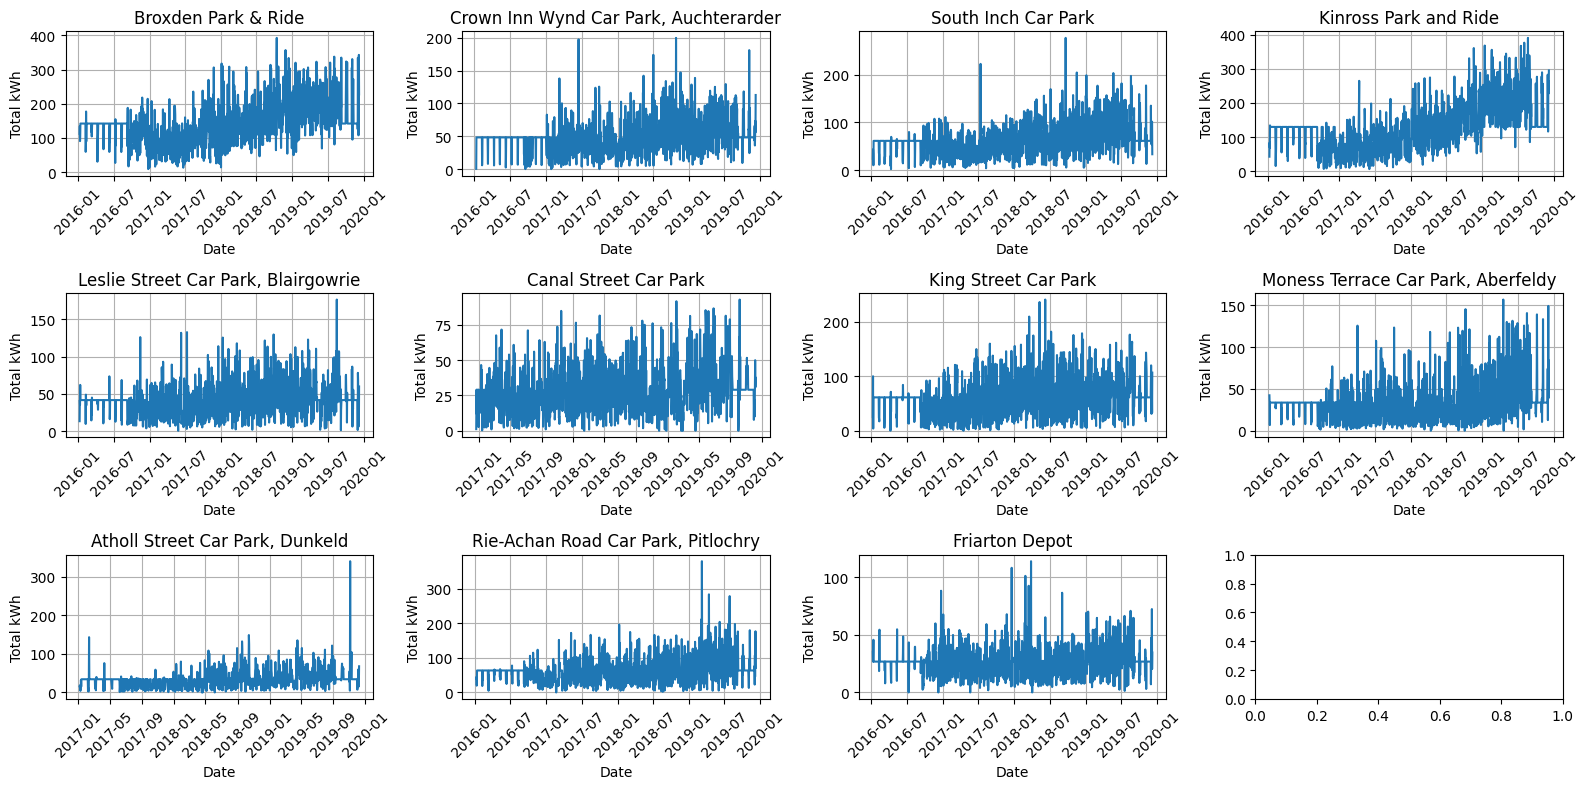

In [32]:
# Define the number of rows and columns for the subplots
num_rows = 3
num_cols = 4

# Create a figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 8))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Iterate over each station and plot on a separate subplot
for i, station in enumerate(stations):
    plot_df = stations_dict[station]['daily']
    ax = axs[i]
    ax.plot(plot_df['Date'], plot_df['Total kWh'])
    ax.set_title(station)
    ax.set_xlabel('Date')
    ax.set_ylabel('Total kWh')
    ax.grid(True)
    plt.setp(ax.get_xticklabels(), rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

### Model definition

In [33]:
class LSTMModel(nn.Module):
      # input_size : number of features in input at each time step
      # hidden_size : Number of LSTM units 
      # num_layers : number of LSTM layers 
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x): # defines forward pass of the neural network
        out, _ = self.lstm(x)
        # extract only the last time step
        out = out[:, -1, :]
        out = self.linear(out)
        return out

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Daily predictions

In [54]:
# Initialize dict for storing predictions
daily_predictions_dict = {}
for station in stations:
    daily_predictions_dict[station] = {'y_test':[], 'y_pred':[], 'rmse':0}

daily_predictions_dict.keys()

dict_keys(['Broxden Park & Ride', 'Crown Inn Wynd Car Park, Auchterarder', 'South Inch Car Park', 'Kinross Park and Ride', 'Leslie Street Car Park, Blairgowrie', 'Canal Street Car Park', 'King Street Car Park', 'Moness Terrace Car Park, Aberfeldy', 'Atholl Street Car Park, Dunkeld', 'Rie-Achan Road Car Park, Pitlochry', 'Friarton Depot'])

In [55]:
def train_lstm(df_dict, type, sequence_length, stations, num_epochs, predictions_dict, test_obs):
    for station in stations:
        print('\n', station, '\n')
        temp_df = df_dict[station][type]['Total kWh']

        # Scaling dataset
        reshaped_data = np.reshape(temp_df, (-1,1))
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = scaler.fit_transform(reshaped_data)

        # Create sequences and labels for training data
        sequence_length = sequence_length  # Number of time steps to look back
        X, y = [], []
        for i in range(len(scaled_data) - sequence_length):
            X.append(scaled_data[i:i+sequence_length])
            y.append(scaled_data[i+sequence_length])
        X, y = np.array(X), np.array(y)

        # Splitting the dataset
        X_train = X[:-test_obs]
        y_train = y[:-test_obs]
        X_test = X[-test_obs:]
        y_test = y[-test_obs:]
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
        # Convert data to PyTorch tensors
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32)
        X_test = torch.tensor(X_test, dtype=torch.float32)
        y_test = torch.tensor(y_test, dtype=torch.float32)
        X_train.shape,y_train.shape

        input_size = 1
        num_layers = 1
        hidden_size = 64
        
        # Define the model, loss function, and optimizer
        model = LSTMModel(input_size, hidden_size, num_layers).to(device)
        
        loss_fn = torch.nn.MSELoss(reduction='mean')
        
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        batch_size = 15
        # Create DataLoader for batch training
        train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        
        # Create DataLoader for batch training
        test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        num_epochs = num_epochs
        train_hist = []
        test_hist = []
        # Training loop
        for epoch in range(num_epochs):
            total_loss = 0.0

            # Training
            model.train()
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                predictions = model(batch_X)
                loss = loss_fn(predictions, batch_y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            # Calculate average training loss and accuracy
            average_loss = total_loss / len(train_loader)
            train_hist.append(average_loss)

            # Validation on test data
            model.eval()
            with torch.no_grad():
                total_test_loss = 0.0

                for batch_X_test, batch_y_test in test_loader:
                    batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
                    predictions_test = model(batch_X_test)
                    test_loss = loss_fn(predictions_test, batch_y_test)

                    total_test_loss += test_loss.item()

                # Calculate average test loss and accuracy
                average_test_loss = total_test_loss / len(test_loader)
                test_hist.append(average_test_loss)
            if (epoch+1)%10==0:
                print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

        #training plot
        x = np.linspace(1,num_epochs,num_epochs)
        plt.plot(x, train_hist, scalex=True, label="Training loss")
        plt.plot(x, test_hist, label="Test loss")
        plt.suptitle(station)
        plt.legend()
        plt.show()
        
        # Set the model to evaluation mode
        model.eval()

        # Move input tensor to the same device as model's parameters
        X_test = X_test.to(device)

        # Pass the entire test set through the model to obtain predictions
        with torch.no_grad():
            # Obtain predictions for the entire test set
            predictions_test = model(X_test)
            
            # Convert predictions from tensors to NumPy arrays
            predictions_test = predictions_test.cpu().numpy()

        # Reverse predictions
        y_test_reversed = scaler.inverse_transform(y_test.reshape(-1, 1))
        predictions_reversed = scaler.inverse_transform(predictions_test.reshape(-1, 1))

        # Save y_test and predictions
        predictions_dict[station]['y_pred'] = predictions_reversed
        predictions_dict[station]['y_test'] = y_test_reversed

        # Calculate mean squared error
        mse = mean_squared_error(y_test_reversed, predictions_reversed)

        # Calculate root mean squared error
        rmse = np.sqrt(mse)

        print(f"{station} Root Mean Squared Error (RMSE):", rmse)
        predictions_dict[station]['rmse'] = rmse


 Broxden Park & Ride 

(1370, 30, 1) (1370, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0239, Test Loss: 0.0219
Epoch [20/50] - Training Loss: 0.0213, Test Loss: 0.0216
Epoch [30/50] - Training Loss: 0.0195, Test Loss: 0.0220
Epoch [40/50] - Training Loss: 0.0185, Test Loss: 0.0214
Epoch [50/50] - Training Loss: 0.0179, Test Loss: 0.0206


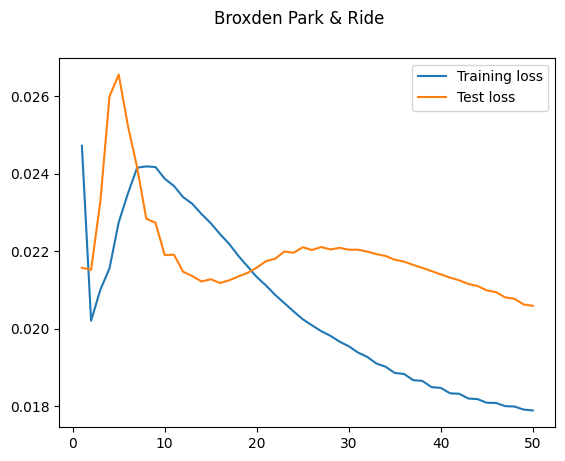

Broxden Park & Ride Root Mean Squared Error (RMSE): 55.058713555718

 Crown Inn Wynd Car Park, Auchterarder 

(1369, 30, 1) (1369, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0166, Test Loss: 0.0066
Epoch [20/50] - Training Loss: 0.0168, Test Loss: 0.0052
Epoch [30/50] - Training Loss: 0.0166, Test Loss: 0.0050
Epoch [40/50] - Training Loss: 0.0162, Test Loss: 0.0052
Epoch [50/50] - Training Loss: 0.0158, Test Loss: 0.0059


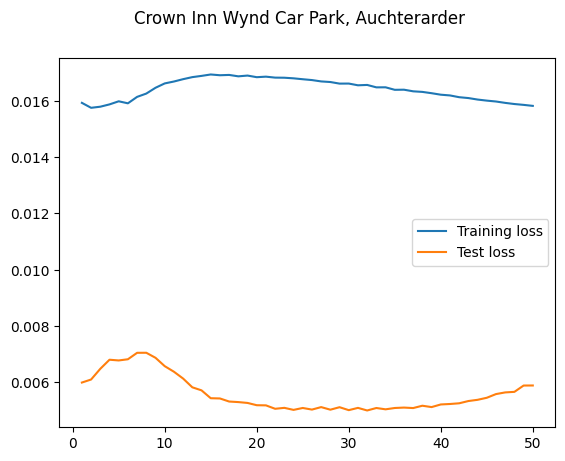

Crown Inn Wynd Car Park, Auchterarder Root Mean Squared Error (RMSE): 15.33980571357357

 South Inch Car Park 

(1370, 30, 1) (1370, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0128, Test Loss: 0.0093
Epoch [20/50] - Training Loss: 0.0138, Test Loss: 0.0093
Epoch [30/50] - Training Loss: 0.0143, Test Loss: 0.0069
Epoch [40/50] - Training Loss: 0.0143, Test Loss: 0.0060
Epoch [50/50] - Training Loss: 0.0140, Test Loss: 0.0058


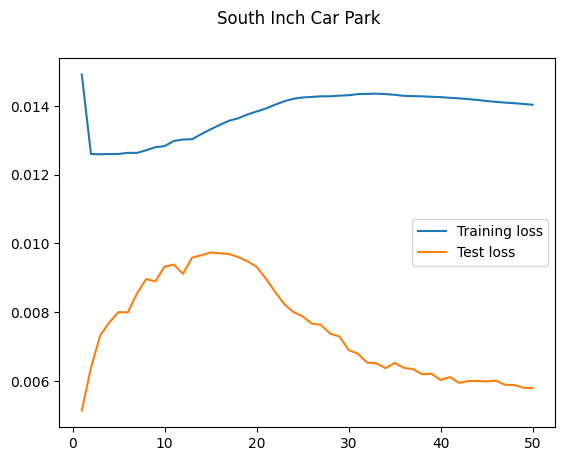

South Inch Car Park Root Mean Squared Error (RMSE): 20.951491662594417

 Kinross Park and Ride 

(1370, 30, 1) (1370, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0226, Test Loss: 0.0299
Epoch [20/50] - Training Loss: 0.0217, Test Loss: 0.0190
Epoch [30/50] - Training Loss: 0.0180, Test Loss: 0.0156
Epoch [40/50] - Training Loss: 0.0171, Test Loss: 0.0148
Epoch [50/50] - Training Loss: 0.0167, Test Loss: 0.0136


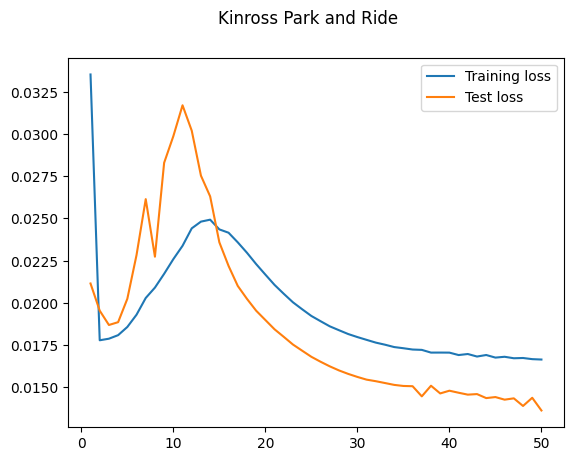

Kinross Park and Ride Root Mean Squared Error (RMSE): 44.89711362402023

 Leslie Street Car Park, Blairgowrie 

(1370, 30, 1) (1370, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0147, Test Loss: 0.0083
Epoch [20/50] - Training Loss: 0.0149, Test Loss: 0.0090
Epoch [30/50] - Training Loss: 0.0150, Test Loss: 0.0090
Epoch [40/50] - Training Loss: 0.0150, Test Loss: 0.0088
Epoch [50/50] - Training Loss: 0.0149, Test Loss: 0.0087


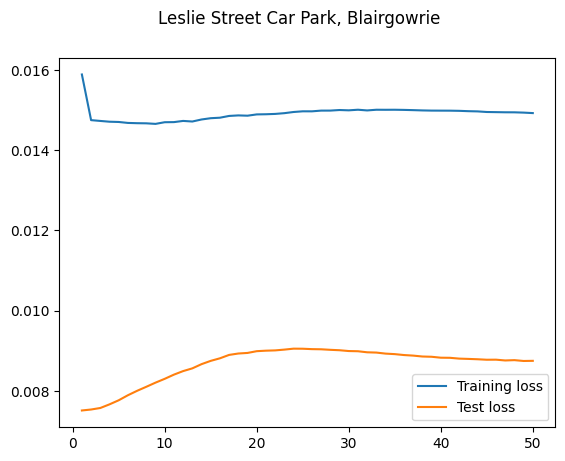

Leslie Street Car Park, Blairgowrie Root Mean Squared Error (RMSE): 16.460327337901667

 Canal Street Car Park 

(1023, 30, 1) (1023, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0346, Test Loss: 0.0118
Epoch [20/50] - Training Loss: 0.0343, Test Loss: 0.0098
Epoch [30/50] - Training Loss: 0.0339, Test Loss: 0.0101
Epoch [40/50] - Training Loss: 0.0335, Test Loss: 0.0088
Epoch [50/50] - Training Loss: 0.0333, Test Loss: 0.0086


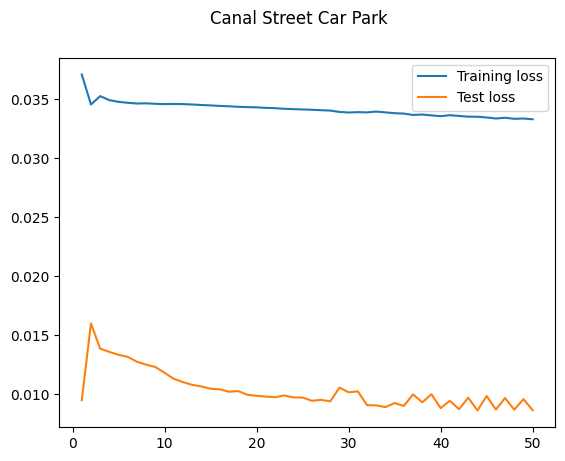

Canal Street Car Park Root Mean Squared Error (RMSE): 8.63016050767228

 King Street Car Park 

(1369, 30, 1) (1369, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0196, Test Loss: 0.0061
Epoch [20/50] - Training Loss: 0.0197, Test Loss: 0.0058
Epoch [30/50] - Training Loss: 0.0197, Test Loss: 0.0059
Epoch [40/50] - Training Loss: 0.0198, Test Loss: 0.0059
Epoch [50/50] - Training Loss: 0.0197, Test Loss: 0.0060


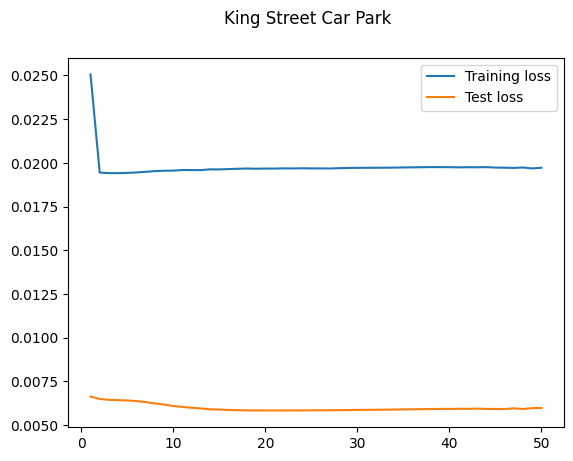

King Street Car Park Root Mean Squared Error (RMSE): 18.62200851798858

 Moness Terrace Car Park, Aberfeldy 

(1369, 30, 1) (1369, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0233, Test Loss: 0.0273
Epoch [20/50] - Training Loss: 0.0234, Test Loss: 0.0254
Epoch [30/50] - Training Loss: 0.0233, Test Loss: 0.0248
Epoch [40/50] - Training Loss: 0.0230, Test Loss: 0.0248
Epoch [50/50] - Training Loss: 0.0227, Test Loss: 0.0252


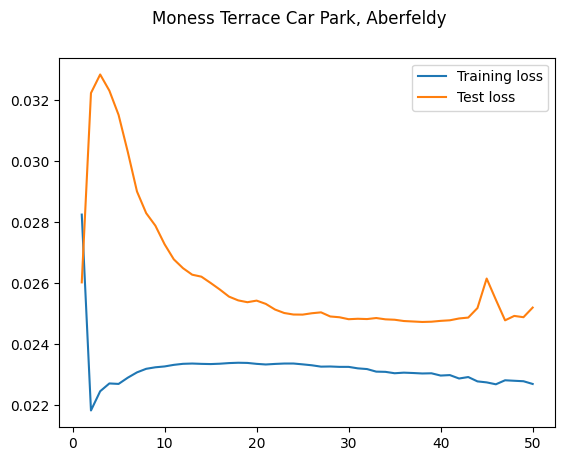

Moness Terrace Car Park, Aberfeldy Root Mean Squared Error (RMSE): 24.862904116258893

 Atholl Street Car Park, Dunkeld 

(1006, 30, 1) (1006, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0052, Test Loss: 0.0026
Epoch [20/50] - Training Loss: 0.0051, Test Loss: 0.0026
Epoch [30/50] - Training Loss: 0.0049, Test Loss: 0.0025
Epoch [40/50] - Training Loss: 0.0047, Test Loss: 0.0026
Epoch [50/50] - Training Loss: 0.0047, Test Loss: 0.0028


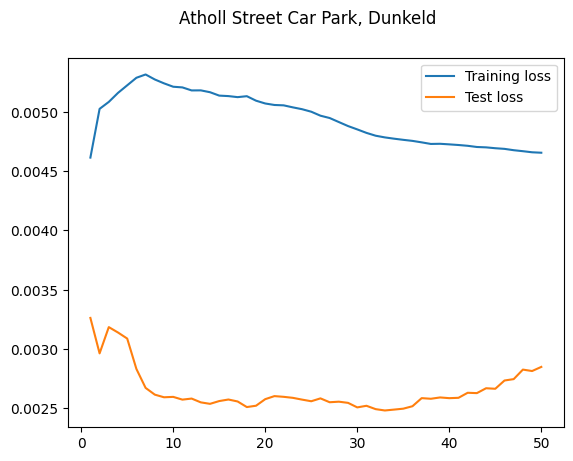

Atholl Street Car Park, Dunkeld Root Mean Squared Error (RMSE): 18.16210421688095

 Rie-Achan Road Car Park, Pitlochry 

(1370, 30, 1) (1370, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0094, Test Loss: 0.0067
Epoch [20/50] - Training Loss: 0.0094, Test Loss: 0.0058
Epoch [30/50] - Training Loss: 0.0093, Test Loss: 0.0053
Epoch [40/50] - Training Loss: 0.0093, Test Loss: 0.0049
Epoch [50/50] - Training Loss: 0.0091, Test Loss: 0.0049


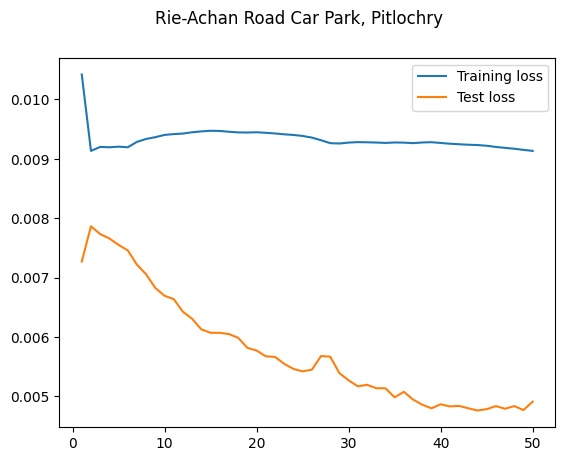

Rie-Achan Road Car Park, Pitlochry Root Mean Squared Error (RMSE): 26.626287403834073

 Friarton Depot 

(1370, 30, 1) (1370, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0121, Test Loss: 0.0085
Epoch [20/50] - Training Loss: 0.0119, Test Loss: 0.0084
Epoch [30/50] - Training Loss: 0.0118, Test Loss: 0.0085
Epoch [40/50] - Training Loss: 0.0118, Test Loss: 0.0084
Epoch [50/50] - Training Loss: 0.0117, Test Loss: 0.0084


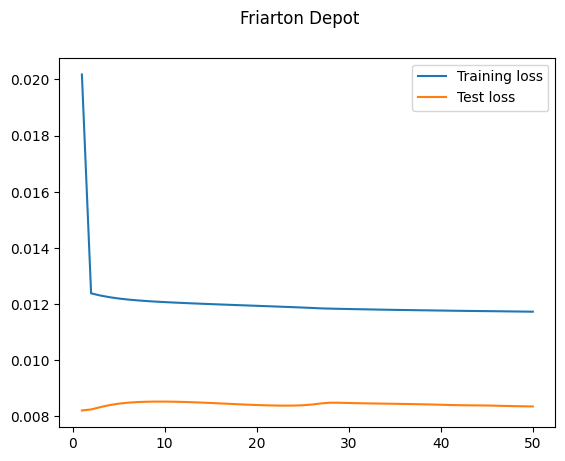

Friarton Depot Root Mean Squared Error (RMSE): 10.429579265683614


In [56]:
train_lstm(df_dict=stations_dict, type='daily', sequence_length=30, stations=stations, 
           num_epochs=50, predictions_dict=daily_predictions_dict, test_obs=30)

In [57]:
# File path to save the dictionary
file_path = 'daily_predictions_perth.pkl'

# Save the dictionary to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(daily_predictions_dict, file)

print(f"Dictionary saved to '{file_path}'")

Dictionary saved to 'daily_predictions_perth.pkl'


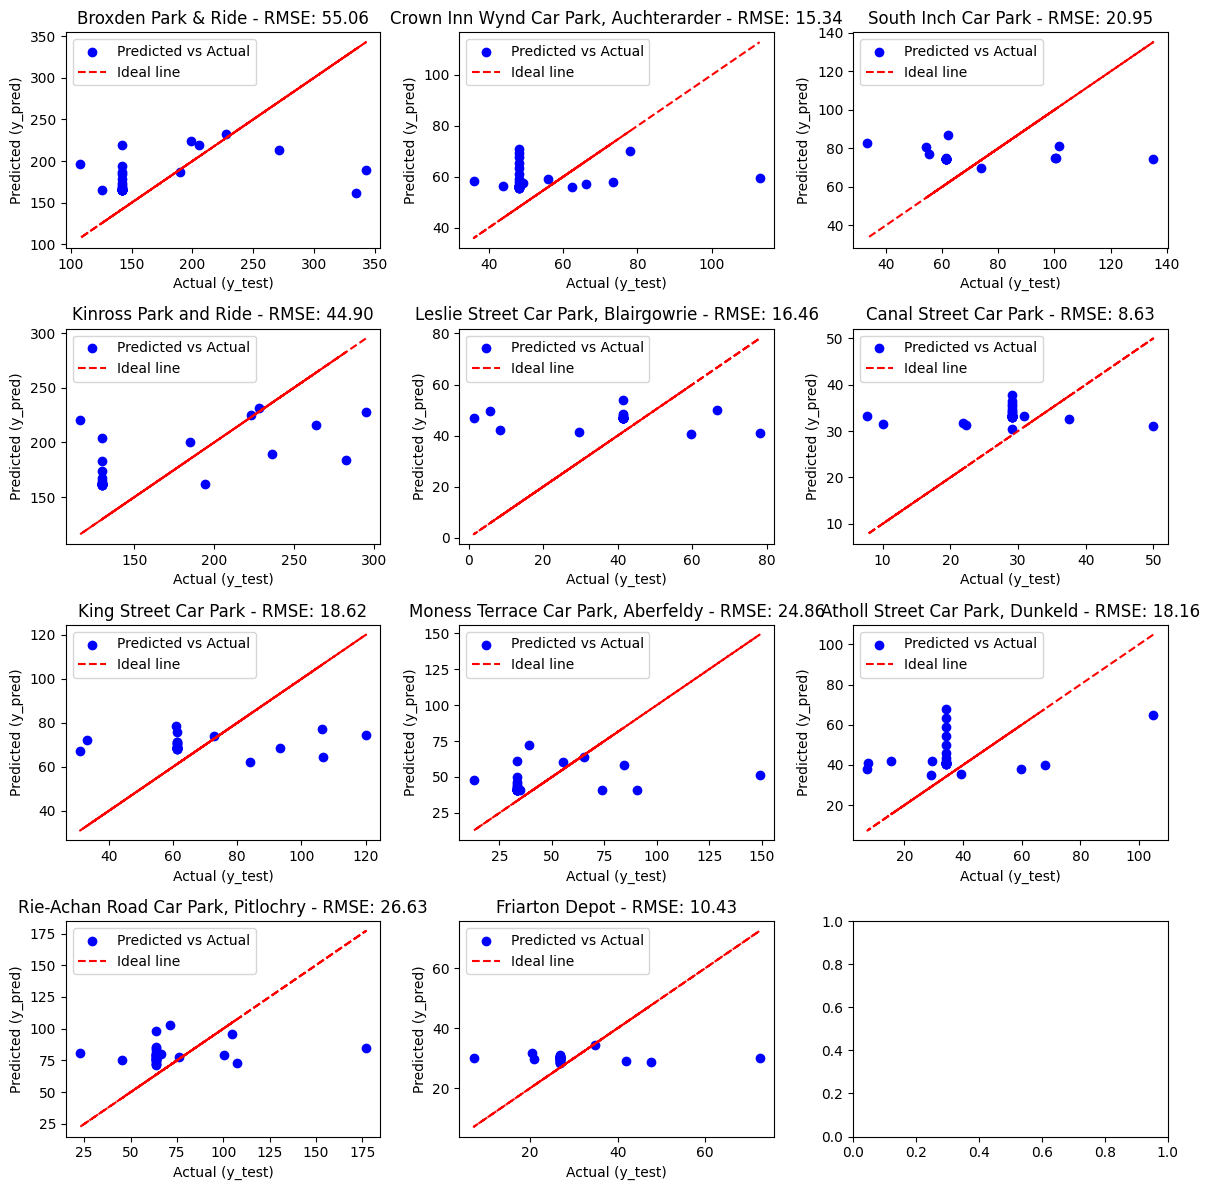

In [58]:
# Define the number of rows and columns for subplots
n_rows = 4
n_cols = 3

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(daily_predictions_dict.keys()):
    # Get data for the current station
    station_data = daily_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot y_pred against y_test
    axs[i].scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
    axs[i].plot(y_test, y_test, color='red', linestyle='--', label='Ideal line')

    axs[i].set_title(f'{station} - RMSE: {rmse:.2f}')
    axs[i].set_xlabel('Actual (y_test)')
    axs[i].set_ylabel('Predicted (y_pred)')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

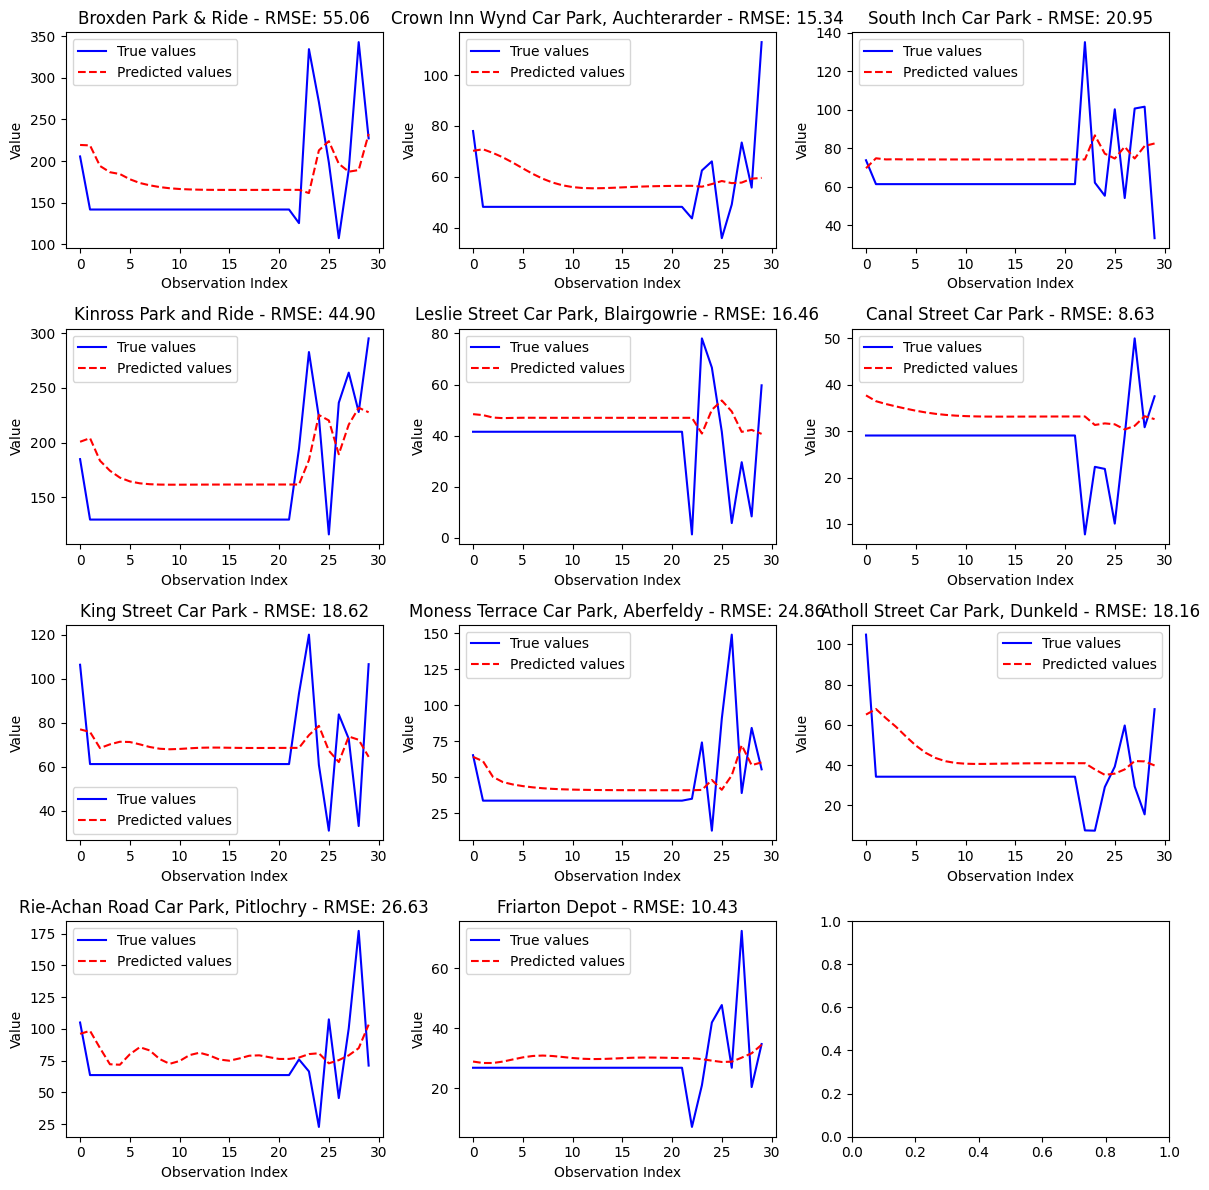

In [59]:
# Define the number of rows and columns for subplots
n_rows = 4
n_cols = 3

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(daily_predictions_dict.keys()):
    # Get data for the current station
    station_data = daily_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot true values and predicted values against the index of observations
    x = np.arange(len(y_test))
    axs[i].plot(x, y_test, color='blue', label='True values')
    axs[i].plot(x, y_pred, color='red', linestyle='--', label='Predicted values')

    axs[i].set_title(f'{station} - RMSE: {rmse:.2f}')
    axs[i].set_xlabel('Observation Index')
    axs[i].set_ylabel('Value')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


### Weekly predictions

In [62]:
# Initialize dict for storing predictions
weekly_predictions_dict = {}
for station in stations:
    weekly_predictions_dict[station] = {'y_test':[], 'y_pred':[], 'rmse':0}

weekly_predictions_dict.keys()

dict_keys(['Broxden Park & Ride', 'Crown Inn Wynd Car Park, Auchterarder', 'South Inch Car Park', 'Kinross Park and Ride', 'Leslie Street Car Park, Blairgowrie', 'Canal Street Car Park', 'King Street Car Park', 'Moness Terrace Car Park, Aberfeldy', 'Atholl Street Car Park, Dunkeld', 'Rie-Achan Road Car Park, Pitlochry', 'Friarton Depot'])


 Broxden Park & Ride 

(163, 30, 1) (163, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0330, Test Loss: 0.0303
Epoch [20/100] - Training Loss: 0.0236, Test Loss: 0.0470
Epoch [30/100] - Training Loss: 0.0234, Test Loss: 0.0458
Epoch [40/100] - Training Loss: 0.0215, Test Loss: 0.0422
Epoch [50/100] - Training Loss: 0.0211, Test Loss: 0.0412
Epoch [60/100] - Training Loss: 0.0211, Test Loss: 0.0422
Epoch [70/100] - Training Loss: 0.0208, Test Loss: 0.0387
Epoch [80/100] - Training Loss: 0.0206, Test Loss: 0.0425
Epoch [90/100] - Training Loss: 0.0207, Test Loss: 0.0408
Epoch [100/100] - Training Loss: 0.0199, Test Loss: 0.0440


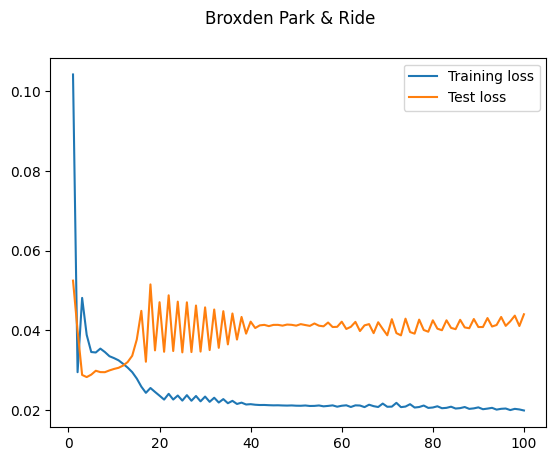

Broxden Park & Ride Root Mean Squared Error (RMSE): 372.0698244552912

 Crown Inn Wynd Car Park, Auchterarder 

(163, 30, 1) (163, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0392, Test Loss: 0.0282
Epoch [20/100] - Training Loss: 0.0351, Test Loss: 0.0326
Epoch [30/100] - Training Loss: 0.0323, Test Loss: 0.0358
Epoch [40/100] - Training Loss: 0.0317, Test Loss: 0.0339
Epoch [50/100] - Training Loss: 0.0314, Test Loss: 0.0329
Epoch [60/100] - Training Loss: 0.0313, Test Loss: 0.0322
Epoch [70/100] - Training Loss: 0.0311, Test Loss: 0.0319
Epoch [80/100] - Training Loss: 0.0310, Test Loss: 0.0317
Epoch [90/100] - Training Loss: 0.0309, Test Loss: 0.0317
Epoch [100/100] - Training Loss: 0.0309, Test Loss: 0.0318


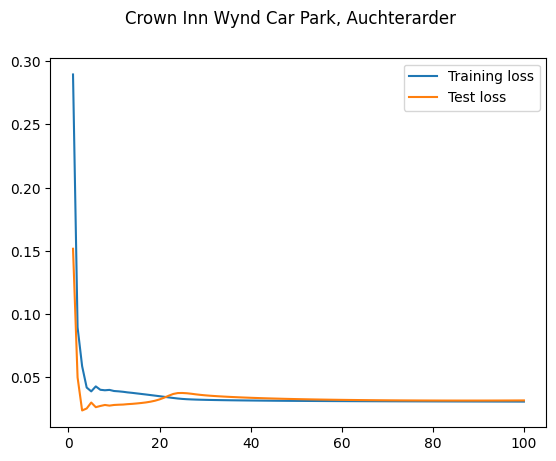

Crown Inn Wynd Car Park, Auchterarder Root Mean Squared Error (RMSE): 110.4449856534453

 South Inch Car Park 

(163, 30, 1) (163, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0329, Test Loss: 0.0292
Epoch [20/100] - Training Loss: 0.0266, Test Loss: 0.0506
Epoch [30/100] - Training Loss: 0.0254, Test Loss: 0.0489
Epoch [40/100] - Training Loss: 0.0249, Test Loss: 0.0472
Epoch [50/100] - Training Loss: 0.0247, Test Loss: 0.0463
Epoch [60/100] - Training Loss: 0.0246, Test Loss: 0.0461
Epoch [70/100] - Training Loss: 0.0245, Test Loss: 0.0457
Epoch [80/100] - Training Loss: 0.0244, Test Loss: 0.0446
Epoch [90/100] - Training Loss: 0.0242, Test Loss: 0.0425
Epoch [100/100] - Training Loss: 0.0243, Test Loss: 0.0415


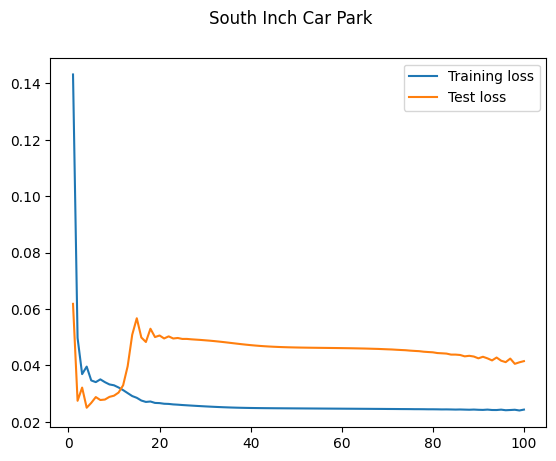

South Inch Car Park Root Mean Squared Error (RMSE): 166.0607069723922

 Kinross Park and Ride 

(163, 30, 1) (163, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0316, Test Loss: 0.0513
Epoch [20/100] - Training Loss: 0.0305, Test Loss: 0.0346
Epoch [30/100] - Training Loss: 0.0257, Test Loss: 0.0428
Epoch [40/100] - Training Loss: 0.0266, Test Loss: 0.0386
Epoch [50/100] - Training Loss: 0.0246, Test Loss: 0.0448
Epoch [60/100] - Training Loss: 0.0229, Test Loss: 0.0506
Epoch [70/100] - Training Loss: 0.0219, Test Loss: 0.0538
Epoch [80/100] - Training Loss: 0.0217, Test Loss: 0.0554
Epoch [90/100] - Training Loss: 0.0214, Test Loss: 0.0580
Epoch [100/100] - Training Loss: 0.0209, Test Loss: 0.0636


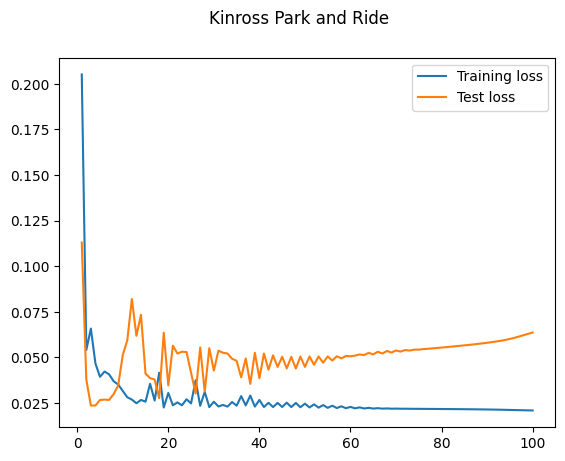

Kinross Park and Ride Root Mean Squared Error (RMSE): 491.0510357278668

 Leslie Street Car Park, Blairgowrie 

(163, 30, 1) (163, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0339, Test Loss: 0.0292
Epoch [20/100] - Training Loss: 0.0316, Test Loss: 0.0307
Epoch [30/100] - Training Loss: 0.0304, Test Loss: 0.0297
Epoch [40/100] - Training Loss: 0.0301, Test Loss: 0.0290
Epoch [50/100] - Training Loss: 0.0300, Test Loss: 0.0286
Epoch [60/100] - Training Loss: 0.0300, Test Loss: 0.0283
Epoch [70/100] - Training Loss: 0.0299, Test Loss: 0.0281
Epoch [80/100] - Training Loss: 0.0299, Test Loss: 0.0279
Epoch [90/100] - Training Loss: 0.0298, Test Loss: 0.0278
Epoch [100/100] - Training Loss: 0.0298, Test Loss: 0.0278


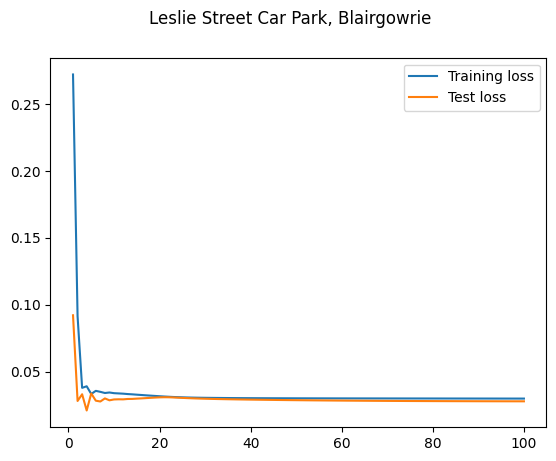

Leslie Street Car Park, Blairgowrie Root Mean Squared Error (RMSE): 91.31342635671662

 Canal Street Car Park 

(113, 30, 1) (113, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0332, Test Loss: 0.0494
Epoch [20/100] - Training Loss: 0.0333, Test Loss: 0.0485
Epoch [30/100] - Training Loss: 0.0332, Test Loss: 0.0486
Epoch [40/100] - Training Loss: 0.0330, Test Loss: 0.0487
Epoch [50/100] - Training Loss: 0.0328, Test Loss: 0.0489
Epoch [60/100] - Training Loss: 0.0326, Test Loss: 0.0493
Epoch [70/100] - Training Loss: 0.0322, Test Loss: 0.0507
Epoch [80/100] - Training Loss: 0.0318, Test Loss: 0.0531
Epoch [90/100] - Training Loss: 0.0307, Test Loss: 0.0510
Epoch [100/100] - Training Loss: 0.0300, Test Loss: 0.0473


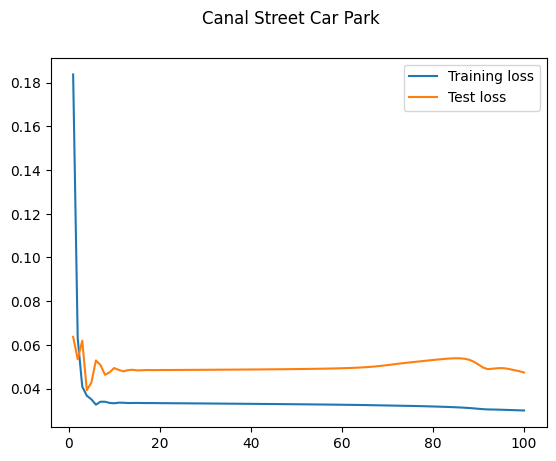

Canal Street Car Park Root Mean Squared Error (RMSE): 74.8901362897116

 King Street Car Park 

(163, 30, 1) (163, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0388, Test Loss: 0.0449
Epoch [20/100] - Training Loss: 0.0333, Test Loss: 0.0531
Epoch [30/100] - Training Loss: 0.0321, Test Loss: 0.0528
Epoch [40/100] - Training Loss: 0.0316, Test Loss: 0.0534
Epoch [50/100] - Training Loss: 0.0313, Test Loss: 0.0537
Epoch [60/100] - Training Loss: 0.0311, Test Loss: 0.0538
Epoch [70/100] - Training Loss: 0.0310, Test Loss: 0.0538
Epoch [80/100] - Training Loss: 0.0309, Test Loss: 0.0539
Epoch [90/100] - Training Loss: 0.0308, Test Loss: 0.0540
Epoch [100/100] - Training Loss: 0.0307, Test Loss: 0.0542


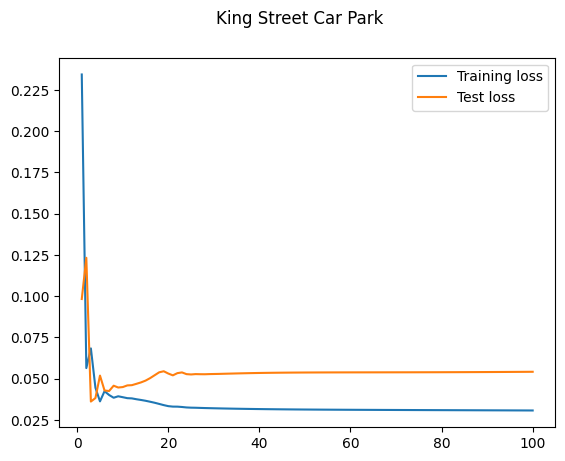

King Street Car Park Root Mean Squared Error (RMSE): 173.50996454920795

 Moness Terrace Car Park, Aberfeldy 

(163, 30, 1) (163, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0349, Test Loss: 0.0481
Epoch [20/100] - Training Loss: 0.0284, Test Loss: 0.0754
Epoch [30/100] - Training Loss: 0.0275, Test Loss: 0.0822
Epoch [40/100] - Training Loss: 0.0272, Test Loss: 0.0810
Epoch [50/100] - Training Loss: 0.0270, Test Loss: 0.0802
Epoch [60/100] - Training Loss: 0.0268, Test Loss: 0.0795
Epoch [70/100] - Training Loss: 0.0267, Test Loss: 0.0783
Epoch [80/100] - Training Loss: 0.0267, Test Loss: 0.0774
Epoch [90/100] - Training Loss: 0.0266, Test Loss: 0.0769
Epoch [100/100] - Training Loss: 0.0266, Test Loss: 0.0767


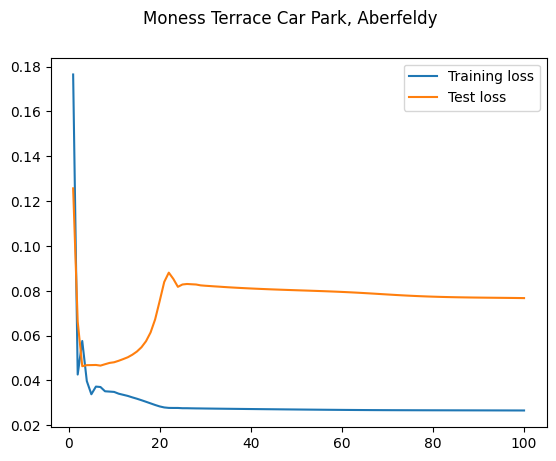

Moness Terrace Car Park, Aberfeldy Root Mean Squared Error (RMSE): 149.1987675993366

 Atholl Street Car Park, Dunkeld 

(111, 30, 1) (111, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0373, Test Loss: 0.0509
Epoch [20/100] - Training Loss: 0.0329, Test Loss: 0.0547
Epoch [30/100] - Training Loss: 0.0309, Test Loss: 0.0574
Epoch [40/100] - Training Loss: 0.0306, Test Loss: 0.0575
Epoch [50/100] - Training Loss: 0.0304, Test Loss: 0.0577
Epoch [60/100] - Training Loss: 0.0302, Test Loss: 0.0579
Epoch [70/100] - Training Loss: 0.0299, Test Loss: 0.0581
Epoch [80/100] - Training Loss: 0.0295, Test Loss: 0.0582
Epoch [90/100] - Training Loss: 0.0291, Test Loss: 0.0580
Epoch [100/100] - Training Loss: 0.0285, Test Loss: 0.0574


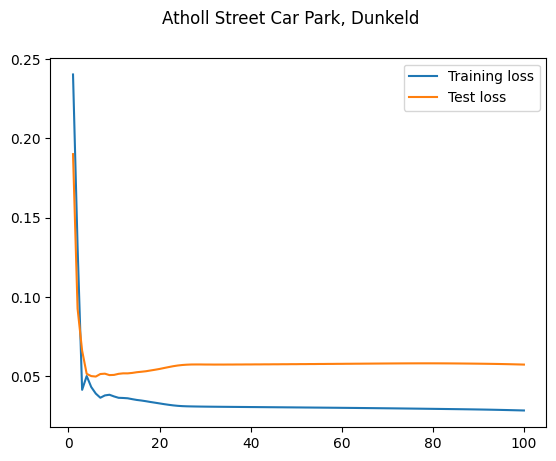

Atholl Street Car Park, Dunkeld Root Mean Squared Error (RMSE): 139.0561748615319

 Rie-Achan Road Car Park, Pitlochry 

(163, 30, 1) (163, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0234, Test Loss: 0.0143
Epoch [20/100] - Training Loss: 0.0206, Test Loss: 0.0307
Epoch [30/100] - Training Loss: 0.0192, Test Loss: 0.0352
Epoch [40/100] - Training Loss: 0.0187, Test Loss: 0.0324
Epoch [50/100] - Training Loss: 0.0184, Test Loss: 0.0299
Epoch [60/100] - Training Loss: 0.0182, Test Loss: 0.0286
Epoch [70/100] - Training Loss: 0.0181, Test Loss: 0.0276
Epoch [80/100] - Training Loss: 0.0180, Test Loss: 0.0268
Epoch [90/100] - Training Loss: 0.0180, Test Loss: 0.0262
Epoch [100/100] - Training Loss: 0.0179, Test Loss: 0.0257


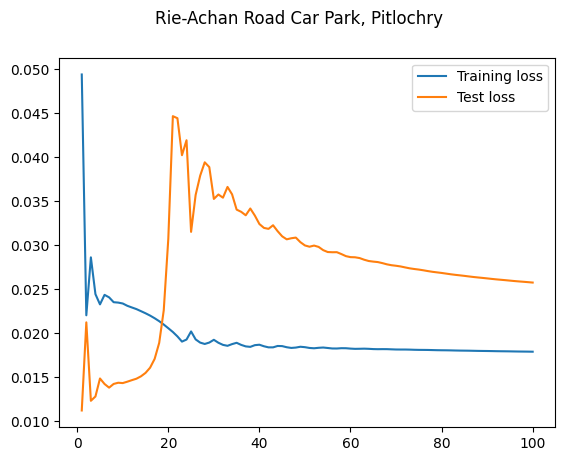

Rie-Achan Road Car Park, Pitlochry Root Mean Squared Error (RMSE): 179.1049165482075

 Friarton Depot 

(163, 30, 1) (163, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0278, Test Loss: 0.0312
Epoch [20/100] - Training Loss: 0.0278, Test Loss: 0.0314
Epoch [30/100] - Training Loss: 0.0278, Test Loss: 0.0313
Epoch [40/100] - Training Loss: 0.0277, Test Loss: 0.0313
Epoch [50/100] - Training Loss: 0.0277, Test Loss: 0.0313
Epoch [60/100] - Training Loss: 0.0277, Test Loss: 0.0313
Epoch [70/100] - Training Loss: 0.0276, Test Loss: 0.0313
Epoch [80/100] - Training Loss: 0.0276, Test Loss: 0.0313
Epoch [90/100] - Training Loss: 0.0275, Test Loss: 0.0314
Epoch [100/100] - Training Loss: 0.0274, Test Loss: 0.0316


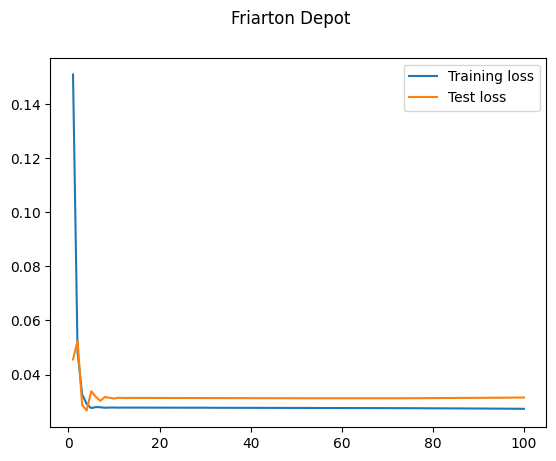

Friarton Depot Root Mean Squared Error (RMSE): 55.23708881376277


In [63]:
train_lstm(df_dict=stations_dict, type='weekly', sequence_length=30, stations=stations, 
           num_epochs=100, predictions_dict=weekly_predictions_dict, test_obs=12)

In [64]:
# File path to save the dictionary
file_path = 'weekly_predictions_perth.pkl'

# Save the dictionary to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(weekly_predictions_dict, file)

print(f"Dictionary saved to '{file_path}'")

Dictionary saved to 'weekly_predictions_perth.pkl'


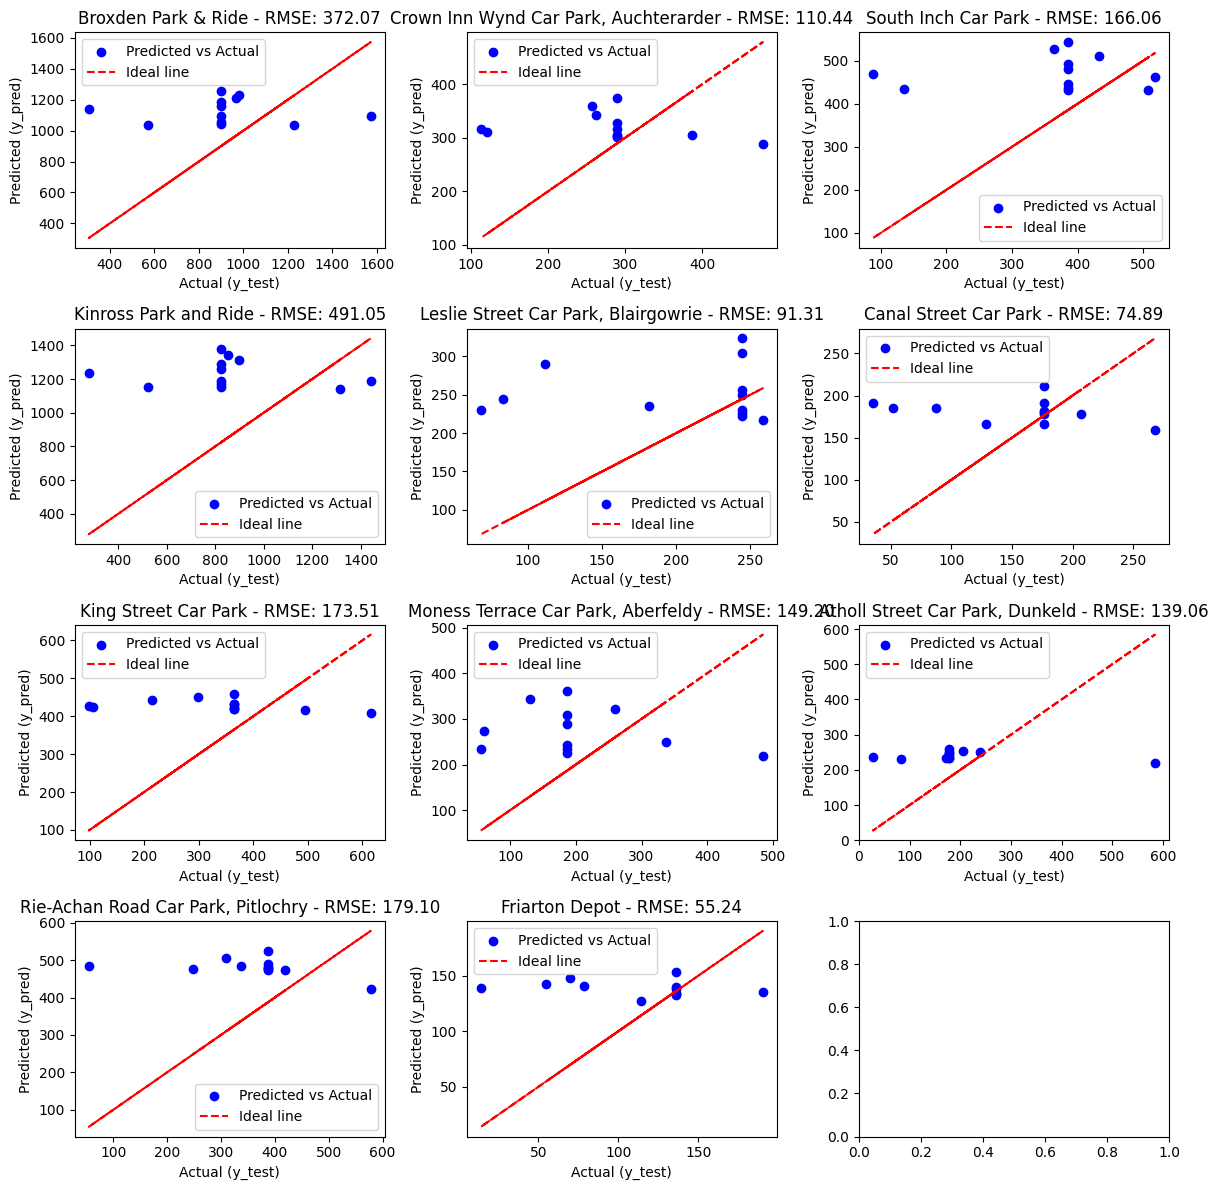

In [65]:
# Define the number of rows and columns for subplots
n_rows = 4
n_cols = 3

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(weekly_predictions_dict.keys()):
    # Get data for the current station
    station_data = weekly_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot y_pred against y_test
    axs[i].scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
    axs[i].plot(y_test, y_test, color='red', linestyle='--', label='Ideal line')

    axs[i].set_title(f'{station} - RMSE: {rmse:.2f}')
    axs[i].set_xlabel('Actual (y_test)')
    axs[i].set_ylabel('Predicted (y_pred)')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

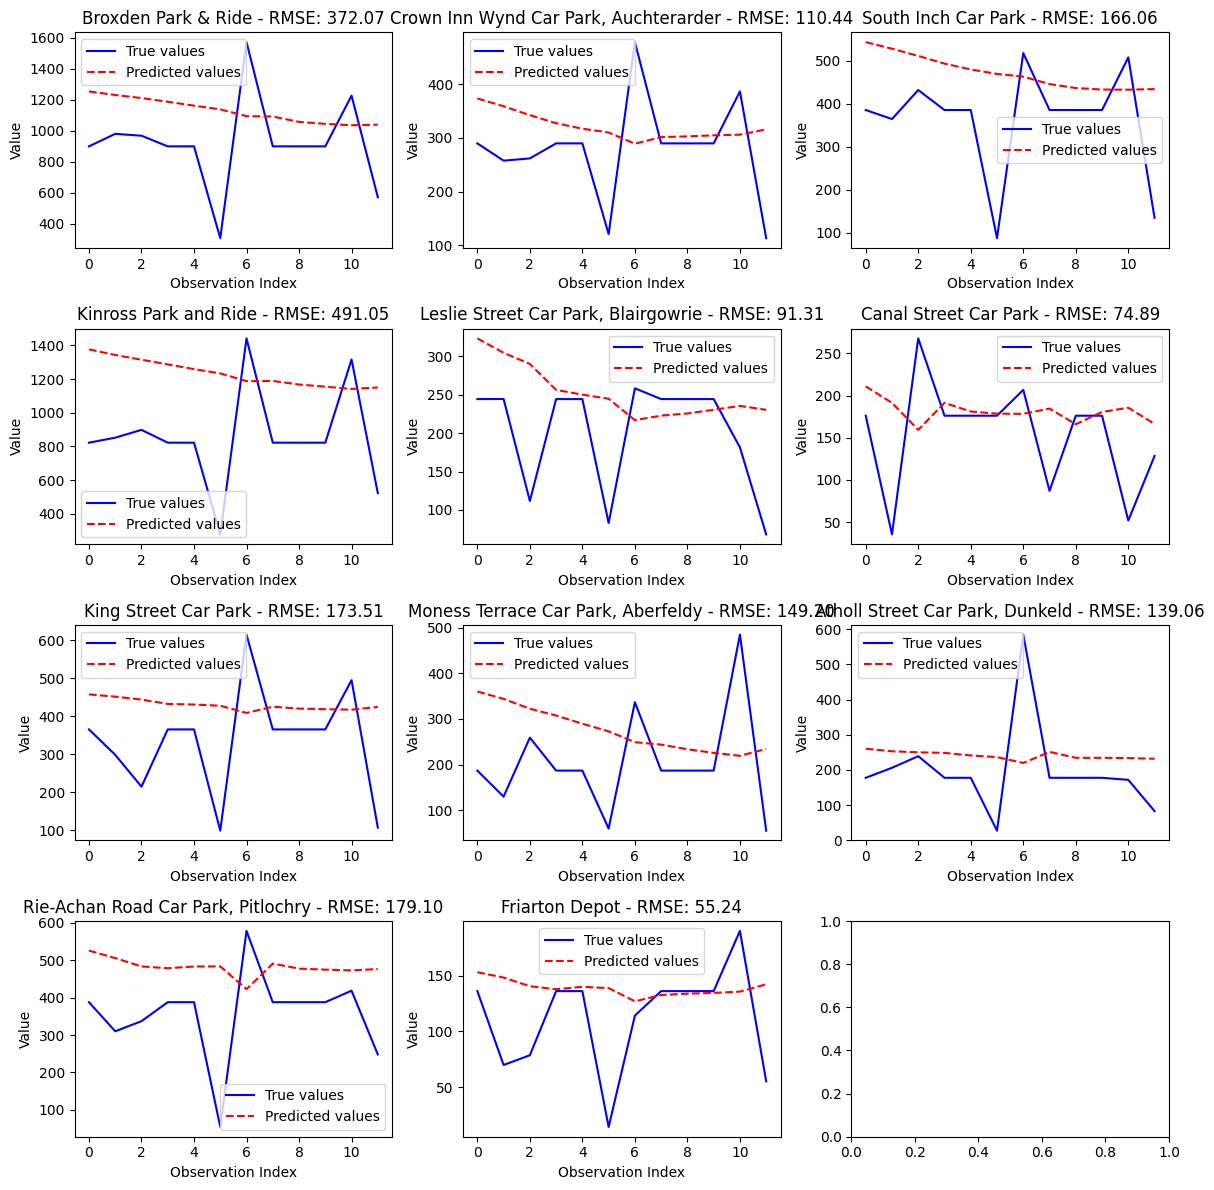

In [66]:
# Define the number of rows and columns for subplots
n_rows = 4
n_cols = 3

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(weekly_predictions_dict.keys()):
    # Get data for the current station
    station_data = weekly_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot true values and predicted values against the index of observations
    x = np.arange(len(y_test))
    axs[i].plot(x, y_test, color='blue', label='True values')
    axs[i].plot(x, y_pred, color='red', linestyle='--', label='Predicted values')

    axs[i].set_title(f'{station} - RMSE: {rmse:.2f}')
    axs[i].set_xlabel('Observation Index')
    axs[i].set_ylabel('Value')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


### Monthly predictions

In [68]:
# Initialize dict for storing predictions
monthly_predictions_dict = {}
for station in stations:
    monthly_predictions_dict[station] = {'y_test':[], 'y_pred':[], 'rmse':0}

monthly_predictions_dict.keys()

dict_keys(['Broxden Park & Ride', 'Crown Inn Wynd Car Park, Auchterarder', 'South Inch Car Park', 'Kinross Park and Ride', 'Leslie Street Car Park, Blairgowrie', 'Canal Street Car Park', 'King Street Car Park', 'Moness Terrace Car Park, Aberfeldy', 'Atholl Street Car Park, Dunkeld', 'Rie-Achan Road Car Park, Pitlochry', 'Friarton Depot'])


 Broxden Park & Ride 

(36, 6, 1) (36, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0387, Test Loss: 0.1869


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0264, Test Loss: 0.1332
Epoch [30/300] - Training Loss: 0.0173, Test Loss: 0.1448
Epoch [40/300] - Training Loss: 0.0116, Test Loss: 0.1560
Epoch [50/300] - Training Loss: 0.0106, Test Loss: 0.1581
Epoch [60/300] - Training Loss: 0.0104, Test Loss: 0.1581
Epoch [70/300] - Training Loss: 0.0103, Test Loss: 0.1577
Epoch [80/300] - Training Loss: 0.0101, Test Loss: 0.1573
Epoch [90/300] - Training Loss: 0.0100, Test Loss: 0.1569
Epoch [100/300] - Training Loss: 0.0099, Test Loss: 0.1566
Epoch [110/300] - Training Loss: 0.0097, Test Loss: 0.1563
Epoch [120/300] - Training Loss: 0.0096, Test Loss: 0.1559
Epoch [130/300] - Training Loss: 0.0095, Test Loss: 0.1556
Epoch [140/300] - Training Loss: 0.0094, Test Loss: 0.1552
Epoch [150/300] - Training Loss: 0.0093, Test Loss: 0.1549
Epoch [160/300] - Training Loss: 0.0092, Test Loss: 0.1545
Epoch [170/300] - Training Loss: 0.0091, Test Loss: 0.1541
Epoch [180/300] - Training Loss: 0.0090, Test Loss: 0.1538
Epoch

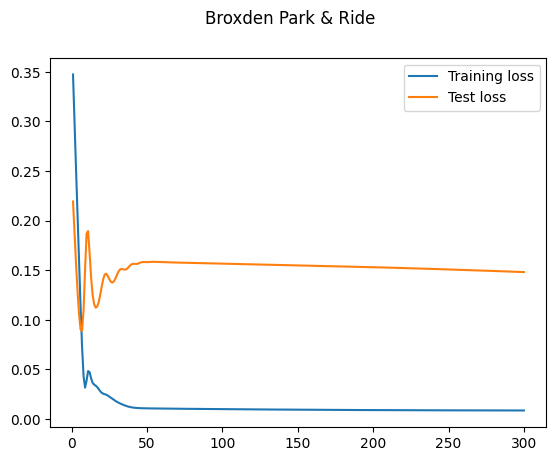

Broxden Park & Ride Root Mean Squared Error (RMSE): 2272.0025906611368

 Crown Inn Wynd Car Park, Auchterarder 

(36, 6, 1) (36, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0745, Test Loss: 0.0836
Epoch [20/300] - Training Loss: 0.0347, Test Loss: 0.1223


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/300] - Training Loss: 0.0288, Test Loss: 0.1438
Epoch [40/300] - Training Loss: 0.0264, Test Loss: 0.1527
Epoch [50/300] - Training Loss: 0.0256, Test Loss: 0.1532
Epoch [60/300] - Training Loss: 0.0251, Test Loss: 0.1526
Epoch [70/300] - Training Loss: 0.0246, Test Loss: 0.1513
Epoch [80/300] - Training Loss: 0.0241, Test Loss: 0.1498
Epoch [90/300] - Training Loss: 0.0236, Test Loss: 0.1483
Epoch [100/300] - Training Loss: 0.0230, Test Loss: 0.1466
Epoch [110/300] - Training Loss: 0.0224, Test Loss: 0.1449
Epoch [120/300] - Training Loss: 0.0217, Test Loss: 0.1430
Epoch [130/300] - Training Loss: 0.0210, Test Loss: 0.1409
Epoch [140/300] - Training Loss: 0.0201, Test Loss: 0.1382
Epoch [150/300] - Training Loss: 0.0192, Test Loss: 0.1345
Epoch [160/300] - Training Loss: 0.0181, Test Loss: 0.1294
Epoch [170/300] - Training Loss: 0.0173, Test Loss: 0.1236
Epoch [180/300] - Training Loss: 0.0168, Test Loss: 0.1193
Epoch [190/300] - Training Loss: 0.0163, Test Loss: 0.1165
Epoc

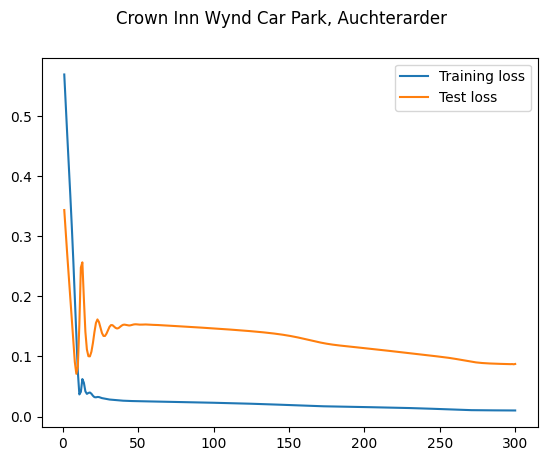

Crown Inn Wynd Car Park, Auchterarder Root Mean Squared Error (RMSE): 595.1994563538397

 South Inch Car Park 

(36, 6, 1) (36, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0435, Test Loss: 0.1545


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0272, Test Loss: 0.1723
Epoch [30/300] - Training Loss: 0.0205, Test Loss: 0.1997
Epoch [40/300] - Training Loss: 0.0150, Test Loss: 0.2269
Epoch [50/300] - Training Loss: 0.0112, Test Loss: 0.2554
Epoch [60/300] - Training Loss: 0.0097, Test Loss: 0.2795
Epoch [70/300] - Training Loss: 0.0095, Test Loss: 0.2898
Epoch [80/300] - Training Loss: 0.0095, Test Loss: 0.2898
Epoch [90/300] - Training Loss: 0.0095, Test Loss: 0.2885
Epoch [100/300] - Training Loss: 0.0094, Test Loss: 0.2876
Epoch [110/300] - Training Loss: 0.0094, Test Loss: 0.2868
Epoch [120/300] - Training Loss: 0.0094, Test Loss: 0.2859
Epoch [130/300] - Training Loss: 0.0094, Test Loss: 0.2850
Epoch [140/300] - Training Loss: 0.0094, Test Loss: 0.2840
Epoch [150/300] - Training Loss: 0.0094, Test Loss: 0.2831
Epoch [160/300] - Training Loss: 0.0093, Test Loss: 0.2821
Epoch [170/300] - Training Loss: 0.0093, Test Loss: 0.2811
Epoch [180/300] - Training Loss: 0.0093, Test Loss: 0.2801
Epoch

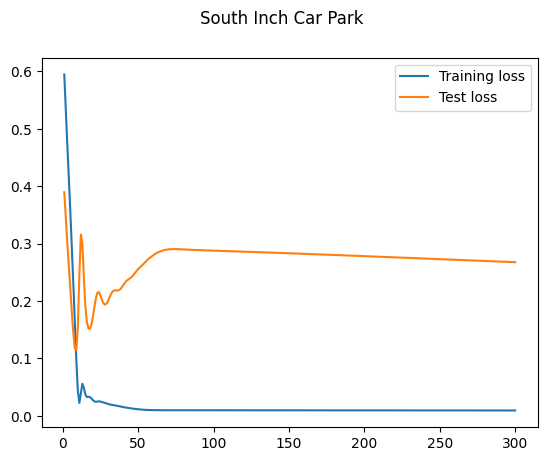

South Inch Car Park Root Mean Squared Error (RMSE): 1304.2833558894315

 Kinross Park and Ride 

(36, 6, 1) (36, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0435, Test Loss: 0.1558
Epoch [20/300] - Training Loss: 0.0357, Test Loss: 0.1245


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/300] - Training Loss: 0.0251, Test Loss: 0.1391
Epoch [40/300] - Training Loss: 0.0145, Test Loss: 0.1632
Epoch [50/300] - Training Loss: 0.0074, Test Loss: 0.1944
Epoch [60/300] - Training Loss: 0.0057, Test Loss: 0.2141
Epoch [70/300] - Training Loss: 0.0056, Test Loss: 0.2152
Epoch [80/300] - Training Loss: 0.0054, Test Loss: 0.2133
Epoch [90/300] - Training Loss: 0.0053, Test Loss: 0.2123
Epoch [100/300] - Training Loss: 0.0052, Test Loss: 0.2113
Epoch [110/300] - Training Loss: 0.0051, Test Loss: 0.2103
Epoch [120/300] - Training Loss: 0.0049, Test Loss: 0.2093
Epoch [130/300] - Training Loss: 0.0048, Test Loss: 0.2083
Epoch [140/300] - Training Loss: 0.0047, Test Loss: 0.2072
Epoch [150/300] - Training Loss: 0.0046, Test Loss: 0.2062
Epoch [160/300] - Training Loss: 0.0045, Test Loss: 0.2051
Epoch [170/300] - Training Loss: 0.0044, Test Loss: 0.2040
Epoch [180/300] - Training Loss: 0.0043, Test Loss: 0.2029
Epoch [190/300] - Training Loss: 0.0042, Test Loss: 0.2018
Epoc

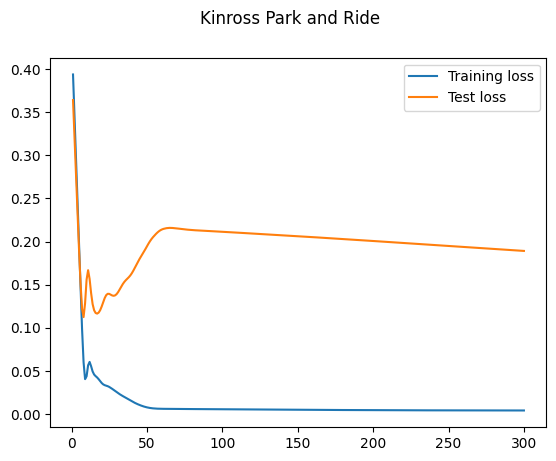

Kinross Park and Ride Root Mean Squared Error (RMSE): 3116.6579850288526

 Leslie Street Car Park, Blairgowrie 

(36, 6, 1) (36, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0437, Test Loss: 0.1808
Epoch [20/300] - Training Loss: 0.0414, Test Loss: 0.1431


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/300] - Training Loss: 0.0383, Test Loss: 0.1426
Epoch [40/300] - Training Loss: 0.0361, Test Loss: 0.1418
Epoch [50/300] - Training Loss: 0.0346, Test Loss: 0.1399
Epoch [60/300] - Training Loss: 0.0336, Test Loss: 0.1382
Epoch [70/300] - Training Loss: 0.0329, Test Loss: 0.1370
Epoch [80/300] - Training Loss: 0.0324, Test Loss: 0.1363
Epoch [90/300] - Training Loss: 0.0319, Test Loss: 0.1360
Epoch [100/300] - Training Loss: 0.0314, Test Loss: 0.1360
Epoch [110/300] - Training Loss: 0.0309, Test Loss: 0.1361
Epoch [120/300] - Training Loss: 0.0304, Test Loss: 0.1364
Epoch [130/300] - Training Loss: 0.0299, Test Loss: 0.1369
Epoch [140/300] - Training Loss: 0.0293, Test Loss: 0.1376
Epoch [150/300] - Training Loss: 0.0287, Test Loss: 0.1385
Epoch [160/300] - Training Loss: 0.0280, Test Loss: 0.1398
Epoch [170/300] - Training Loss: 0.0272, Test Loss: 0.1417
Epoch [180/300] - Training Loss: 0.0263, Test Loss: 0.1443
Epoch [190/300] - Training Loss: 0.0253, Test Loss: 0.1482
Epoc

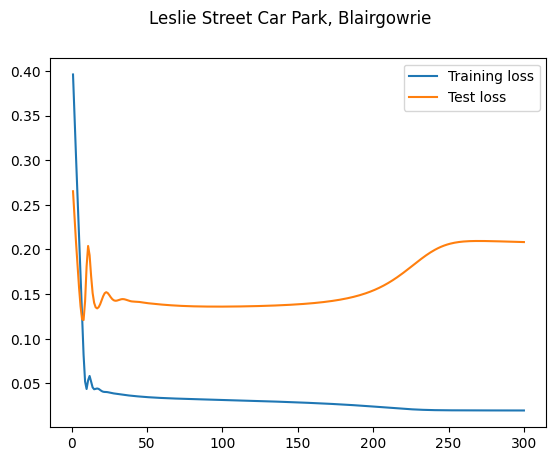

Leslie Street Car Park, Blairgowrie Root Mean Squared Error (RMSE): 794.477439355636

 Canal Street Car Park 

(25, 6, 1) (25, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0641, Test Loss: 0.0953
Epoch [20/300] - Training Loss: 0.0161, Test Loss: 0.1543
Epoch [30/300] - Training Loss: 0.0159, Test Loss: 0.1820


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [40/300] - Training Loss: 0.0158, Test Loss: 0.1619
Epoch [50/300] - Training Loss: 0.0157, Test Loss: 0.1685
Epoch [60/300] - Training Loss: 0.0156, Test Loss: 0.1691
Epoch [70/300] - Training Loss: 0.0155, Test Loss: 0.1682
Epoch [80/300] - Training Loss: 0.0155, Test Loss: 0.1680
Epoch [90/300] - Training Loss: 0.0154, Test Loss: 0.1680
Epoch [100/300] - Training Loss: 0.0154, Test Loss: 0.1680
Epoch [110/300] - Training Loss: 0.0153, Test Loss: 0.1680
Epoch [120/300] - Training Loss: 0.0152, Test Loss: 0.1679
Epoch [130/300] - Training Loss: 0.0152, Test Loss: 0.1678
Epoch [140/300] - Training Loss: 0.0151, Test Loss: 0.1678
Epoch [150/300] - Training Loss: 0.0150, Test Loss: 0.1677
Epoch [160/300] - Training Loss: 0.0150, Test Loss: 0.1677
Epoch [170/300] - Training Loss: 0.0149, Test Loss: 0.1676
Epoch [180/300] - Training Loss: 0.0148, Test Loss: 0.1675
Epoch [190/300] - Training Loss: 0.0148, Test Loss: 0.1675
Epoch [200/300] - Training Loss: 0.0147, Test Loss: 0.1674
Epo

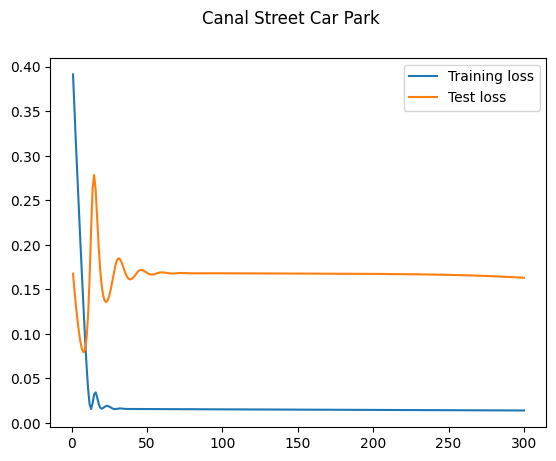

Canal Street Car Park Root Mean Squared Error (RMSE): 471.0597547969954

 King Street Car Park 

(36, 6, 1) (36, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0274, Test Loss: 0.1884


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0260, Test Loss: 0.1503
Epoch [30/300] - Training Loss: 0.0219, Test Loss: 0.1540
Epoch [40/300] - Training Loss: 0.0188, Test Loss: 0.1565
Epoch [50/300] - Training Loss: 0.0172, Test Loss: 0.1565
Epoch [60/300] - Training Loss: 0.0167, Test Loss: 0.1563
Epoch [70/300] - Training Loss: 0.0164, Test Loss: 0.1561
Epoch [80/300] - Training Loss: 0.0163, Test Loss: 0.1558
Epoch [90/300] - Training Loss: 0.0161, Test Loss: 0.1556
Epoch [100/300] - Training Loss: 0.0159, Test Loss: 0.1553
Epoch [110/300] - Training Loss: 0.0158, Test Loss: 0.1550
Epoch [120/300] - Training Loss: 0.0156, Test Loss: 0.1548
Epoch [130/300] - Training Loss: 0.0154, Test Loss: 0.1545
Epoch [140/300] - Training Loss: 0.0152, Test Loss: 0.1543
Epoch [150/300] - Training Loss: 0.0150, Test Loss: 0.1541
Epoch [160/300] - Training Loss: 0.0147, Test Loss: 0.1538
Epoch [170/300] - Training Loss: 0.0145, Test Loss: 0.1536
Epoch [180/300] - Training Loss: 0.0142, Test Loss: 0.1533
Epoch

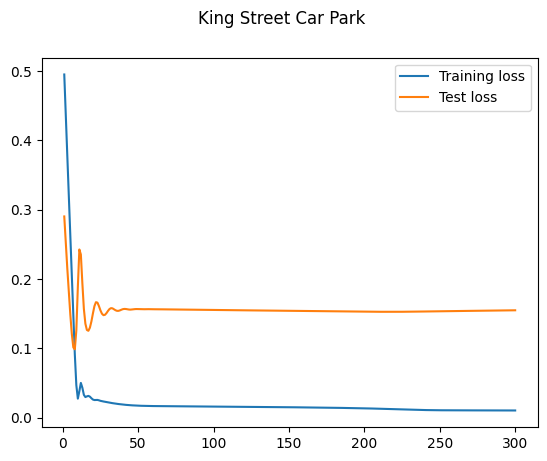

King Street Car Park Root Mean Squared Error (RMSE): 969.2186768709214

 Moness Terrace Car Park, Aberfeldy 

(36, 6, 1) (36, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0383, Test Loss: 0.1237


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0322, Test Loss: 0.1056
Epoch [30/300] - Training Loss: 0.0292, Test Loss: 0.1104
Epoch [40/300] - Training Loss: 0.0256, Test Loss: 0.1204
Epoch [50/300] - Training Loss: 0.0219, Test Loss: 0.1377
Epoch [60/300] - Training Loss: 0.0183, Test Loss: 0.1697
Epoch [70/300] - Training Loss: 0.0157, Test Loss: 0.2212
Epoch [80/300] - Training Loss: 0.0147, Test Loss: 0.2679
Epoch [90/300] - Training Loss: 0.0145, Test Loss: 0.2803
Epoch [100/300] - Training Loss: 0.0143, Test Loss: 0.2777
Epoch [110/300] - Training Loss: 0.0141, Test Loss: 0.2747
Epoch [120/300] - Training Loss: 0.0139, Test Loss: 0.2720
Epoch [130/300] - Training Loss: 0.0137, Test Loss: 0.2692
Epoch [140/300] - Training Loss: 0.0135, Test Loss: 0.2662
Epoch [150/300] - Training Loss: 0.0133, Test Loss: 0.2629
Epoch [160/300] - Training Loss: 0.0131, Test Loss: 0.2593
Epoch [170/300] - Training Loss: 0.0129, Test Loss: 0.2555
Epoch [180/300] - Training Loss: 0.0127, Test Loss: 0.2513
Epoch

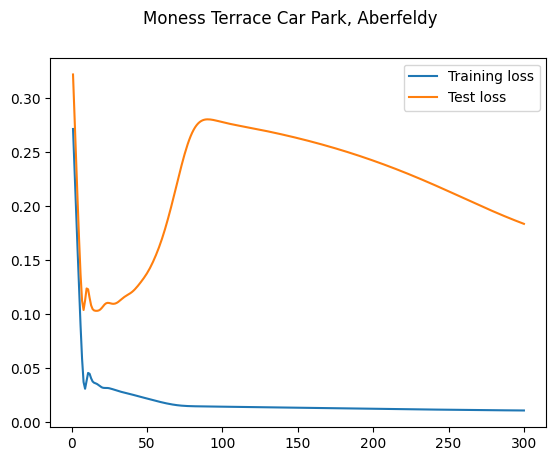

Moness Terrace Car Park, Aberfeldy Root Mean Squared Error (RMSE): 791.6617300307844

 Atholl Street Car Park, Dunkeld 

(24, 6, 1) (24, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0737, Test Loss: 0.0839
Epoch [20/300] - Training Loss: 0.0491, Test Loss: 0.1080


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/300] - Training Loss: 0.0407, Test Loss: 0.1316
Epoch [40/300] - Training Loss: 0.0343, Test Loss: 0.1348
Epoch [50/300] - Training Loss: 0.0303, Test Loss: 0.1535
Epoch [60/300] - Training Loss: 0.0292, Test Loss: 0.1622
Epoch [70/300] - Training Loss: 0.0284, Test Loss: 0.1605
Epoch [80/300] - Training Loss: 0.0276, Test Loss: 0.1579
Epoch [90/300] - Training Loss: 0.0269, Test Loss: 0.1563
Epoch [100/300] - Training Loss: 0.0261, Test Loss: 0.1548
Epoch [110/300] - Training Loss: 0.0253, Test Loss: 0.1531
Epoch [120/300] - Training Loss: 0.0244, Test Loss: 0.1515
Epoch [130/300] - Training Loss: 0.0234, Test Loss: 0.1498
Epoch [140/300] - Training Loss: 0.0224, Test Loss: 0.1479
Epoch [150/300] - Training Loss: 0.0213, Test Loss: 0.1459
Epoch [160/300] - Training Loss: 0.0203, Test Loss: 0.1435
Epoch [170/300] - Training Loss: 0.0195, Test Loss: 0.1407
Epoch [180/300] - Training Loss: 0.0189, Test Loss: 0.1377
Epoch [190/300] - Training Loss: 0.0184, Test Loss: 0.1344
Epoc

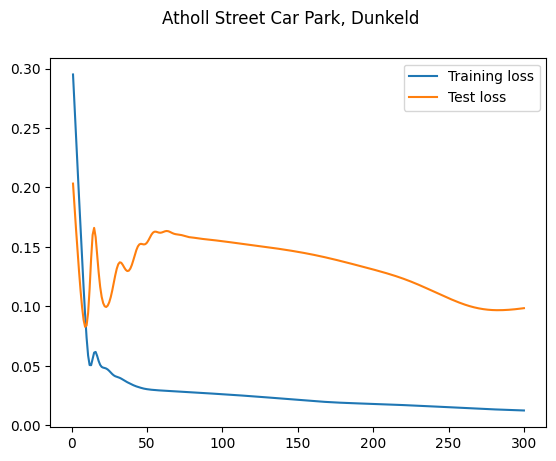

Atholl Street Car Park, Dunkeld Root Mean Squared Error (RMSE): 427.35013833283193

 Rie-Achan Road Car Park, Pitlochry 

(36, 6, 1) (36, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0416, Test Loss: 0.1723


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0262, Test Loss: 0.1366
Epoch [30/300] - Training Loss: 0.0232, Test Loss: 0.1387
Epoch [40/300] - Training Loss: 0.0197, Test Loss: 0.1507
Epoch [50/300] - Training Loss: 0.0167, Test Loss: 0.1726
Epoch [60/300] - Training Loss: 0.0158, Test Loss: 0.1890
Epoch [70/300] - Training Loss: 0.0156, Test Loss: 0.1864
Epoch [80/300] - Training Loss: 0.0154, Test Loss: 0.1828
Epoch [90/300] - Training Loss: 0.0152, Test Loss: 0.1801
Epoch [100/300] - Training Loss: 0.0151, Test Loss: 0.1774
Epoch [110/300] - Training Loss: 0.0149, Test Loss: 0.1746
Epoch [120/300] - Training Loss: 0.0148, Test Loss: 0.1719
Epoch [130/300] - Training Loss: 0.0146, Test Loss: 0.1692
Epoch [140/300] - Training Loss: 0.0145, Test Loss: 0.1666
Epoch [150/300] - Training Loss: 0.0144, Test Loss: 0.1640
Epoch [160/300] - Training Loss: 0.0143, Test Loss: 0.1615
Epoch [170/300] - Training Loss: 0.0142, Test Loss: 0.1591
Epoch [180/300] - Training Loss: 0.0141, Test Loss: 0.1568
Epoch

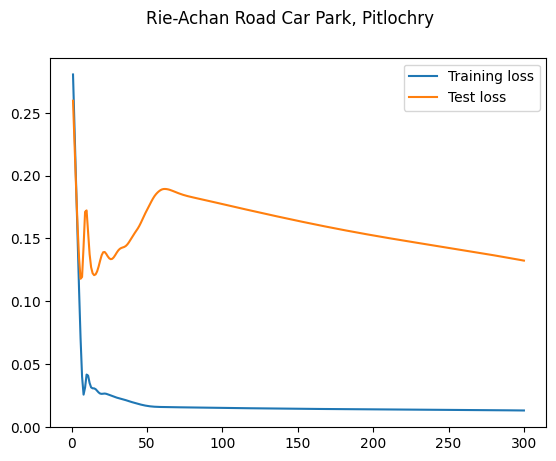

Rie-Achan Road Car Park, Pitlochry Root Mean Squared Error (RMSE): 1138.1754906629124

 Friarton Depot 

(36, 6, 1) (36, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0250, Test Loss: 0.2164
Epoch [20/300] - Training Loss: 0.0260, Test Loss: 0.1565


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/300] - Training Loss: 0.0254, Test Loss: 0.1550
Epoch [40/300] - Training Loss: 0.0247, Test Loss: 0.1556
Epoch [50/300] - Training Loss: 0.0241, Test Loss: 0.1553
Epoch [60/300] - Training Loss: 0.0236, Test Loss: 0.1547
Epoch [70/300] - Training Loss: 0.0233, Test Loss: 0.1541
Epoch [80/300] - Training Loss: 0.0231, Test Loss: 0.1533
Epoch [90/300] - Training Loss: 0.0229, Test Loss: 0.1521
Epoch [100/300] - Training Loss: 0.0227, Test Loss: 0.1508
Epoch [110/300] - Training Loss: 0.0225, Test Loss: 0.1492
Epoch [120/300] - Training Loss: 0.0223, Test Loss: 0.1473
Epoch [130/300] - Training Loss: 0.0220, Test Loss: 0.1453
Epoch [140/300] - Training Loss: 0.0217, Test Loss: 0.1431
Epoch [150/300] - Training Loss: 0.0213, Test Loss: 0.1406
Epoch [160/300] - Training Loss: 0.0209, Test Loss: 0.1380
Epoch [170/300] - Training Loss: 0.0204, Test Loss: 0.1354
Epoch [180/300] - Training Loss: 0.0197, Test Loss: 0.1333
Epoch [190/300] - Training Loss: 0.0188, Test Loss: 0.1325
Epoc

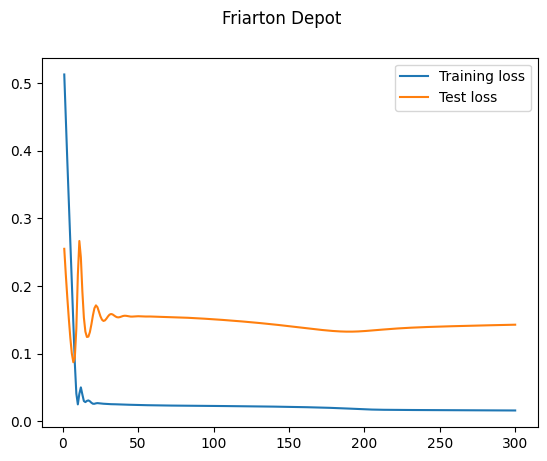

Friarton Depot Root Mean Squared Error (RMSE): 335.8191763766977


In [69]:
train_lstm(df_dict=stations_dict, type='monthly', sequence_length=6, stations=stations, 
           num_epochs=300, predictions_dict=monthly_predictions_dict, test_obs=6)

In [70]:
# File path to save the dictionary
file_path = 'monthly_predictions_perth.pkl'

# Save the dictionary to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(monthly_predictions_dict, file)

print(f"Dictionary saved to '{file_path}'")

Dictionary saved to 'monthly_predictions_perth.pkl'


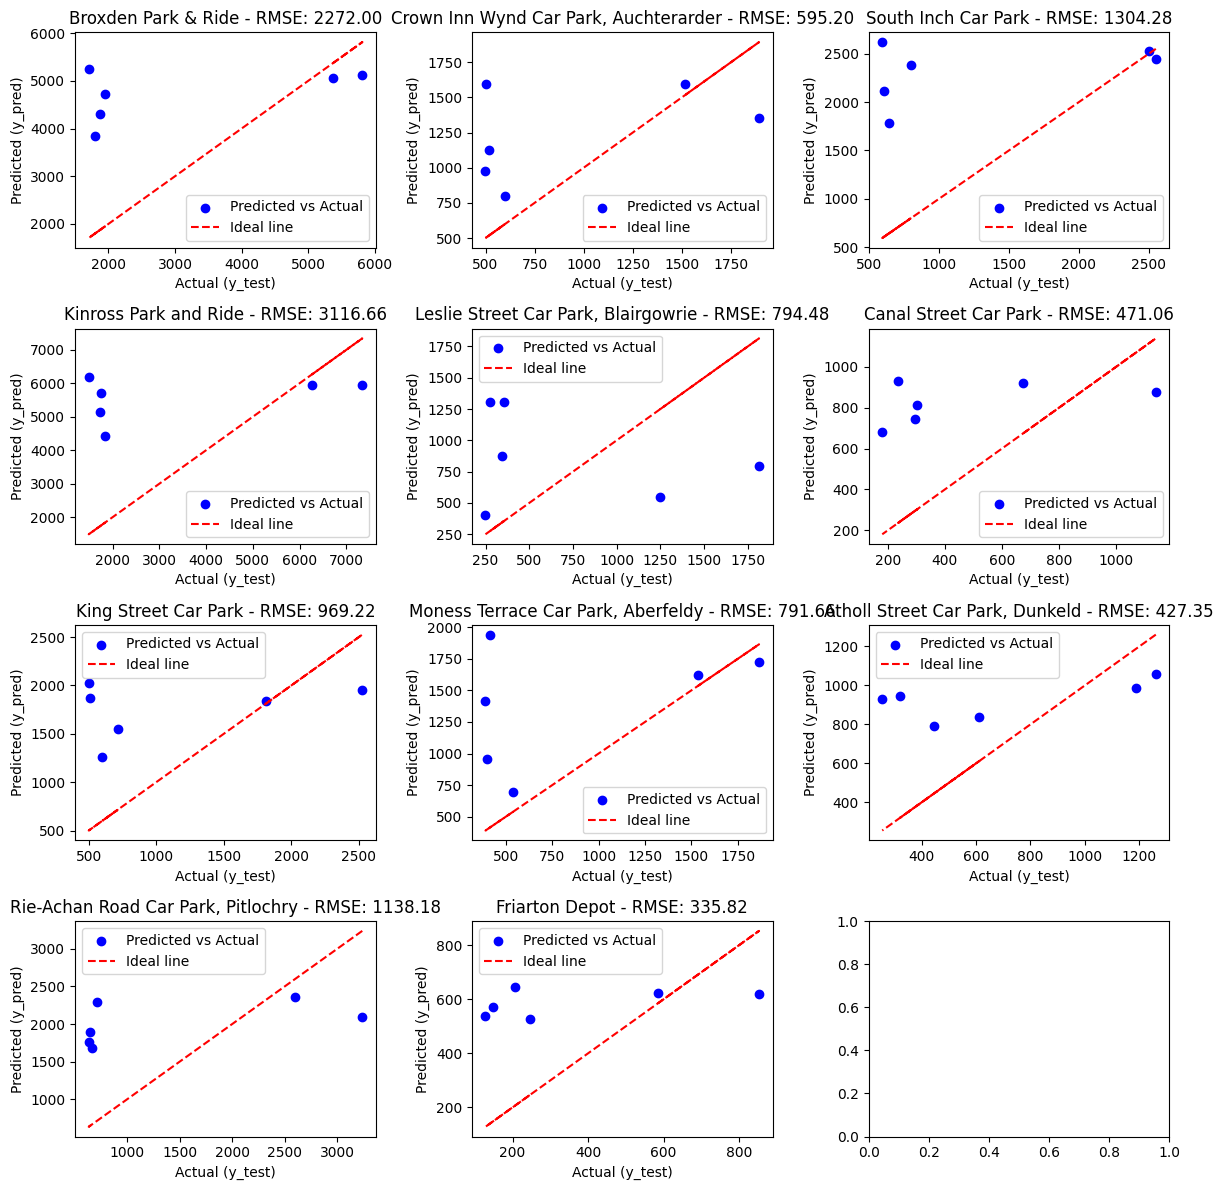

In [71]:
# Define the number of rows and columns for subplots
n_rows = 4
n_cols = 3

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(monthly_predictions_dict.keys()):
    # Get data for the current station
    station_data = monthly_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot y_pred against y_test
    axs[i].scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
    axs[i].plot(y_test, y_test, color='red', linestyle='--', label='Ideal line')

    axs[i].set_title(f'{station} - RMSE: {rmse:.2f}')
    axs[i].set_xlabel('Actual (y_test)')
    axs[i].set_ylabel('Predicted (y_pred)')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

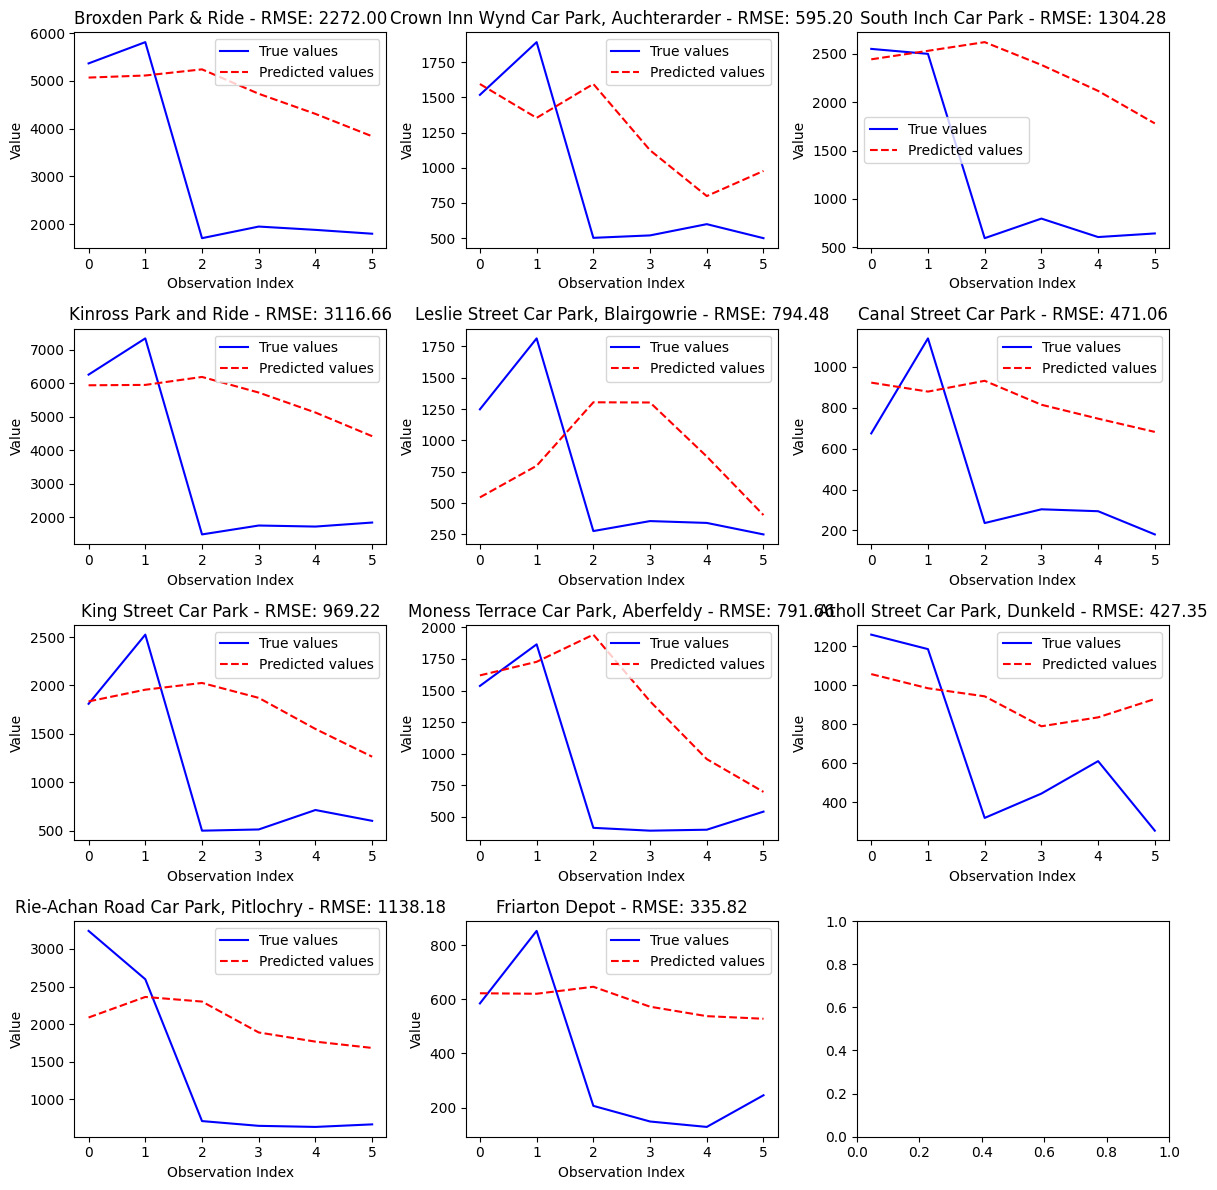

In [72]:
# Define the number of rows and columns for subplots
n_rows = 4
n_cols = 3

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(monthly_predictions_dict.keys()):
    # Get data for the current station
    station_data = monthly_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot true values and predicted values against the index of observations
    x = np.arange(len(y_test))
    axs[i].plot(x, y_test, color='blue', label='True values')
    axs[i].plot(x, y_pred, color='red', linestyle='--', label='Predicted values')

    axs[i].set_title(f'{station} - RMSE: {rmse:.2f}')
    axs[i].set_xlabel('Observation Index')
    axs[i].set_ylabel('Value')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


### Conclusions